# Analysis of the StackOverflow Survey Dataset

In [13]:
# Load the necessary libraries
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%precision 4
# %matplotlib  notebook
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)    # Ignore future warnings in pandas (and other packages)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter
from IPython import display
import os.path as path
import re
import plotly.express as px
import pycountry
import seaborn as sn
from itertools import chain

from useful_funcs import *

## Part 1. Reading the Data

We need to standardize the data to facilitate the comparison and analysis. The datasets from 2011-2016 have different encoding than the later ones.

In [4]:
# ----- 2011 -----
# find_encoding('data\\developer_survey_2011\\2011 Stack Overflow Survey Results.csv')
df = pd.read_csv('data\\developer_survey_2011\\2011 Stack Overflow Survey Results.csv', encoding='ISO-8859-1', \
                 dtype=str, header=[0,1], skipinitialspace=True)             # 'iso8859_2' also works
df = rename_top_level(df)

print('Original shape:', df.shape)

df.drop(columns=df.columns[(df.isnull().sum() == df.shape[0])], inplace=True)       # Drop all empty columns

df = merge_multichoice(df)

# Fix the values in the third column (ranges have been misinterpreted as dates; specifically '2-5' became 5/2/2013 = 41310 
# and '6-10' -- 10/6/2013 = 41435)
df.replace({'How many years of IT/Programming experience do you have?': {'41310':'2-5', '41435':'6-10', '11':'>11'}}, inplace=True)

# Rename the columns; define a mapping dictionary in the format key-val as new_name-old_name
schema = {'Country'        : 'What Country or Region do you live in?',
          'USState'        : 'Which US State or Territory do you live in?',
          'AgeBracket'     : 'How old are you?',
          'YearsProgram'   : 'How many years of IT/Programming experience do you have?',
          'Industry'       : 'How would you best describe the industry you work in?',
          'CompanySize'    : 'Which best describes the size of your company?',
          'DeveloperType'  : 'Which of the following best describes your occupation?',
          'RecommendationActed' : 'How likely is it that a recommendation you make will be acted upon?',
          'ProjectType'    : 'What type of project are you developing?',
          'OperatingSystem': 'What operating system do you use the most?',
          'JobCareerSatisfaction' : 'Please rate your job/career satisfaction',
          'SalaryBracketUSD'         : 'Including bonus, what is your annual compensation in USD?',
          'MoneySpentPersonal' : 'In the last 12 months, how much money have you spent on personal technology-related purchases?',
          'StackOverflowSites' : 'Which of our sites do you frequent most?',
          'PurchaseTypes'  : 'What types of purchases are you involved in? (MERGED)',
          'OwnProducts'    : 'Which technology products do you own? (You can choose more than one) (MERGED)',
          'BudgetOutside'  : 'What is your budget for outside expenditures (hardware, software, consulting, etc) for 2011? (MERGED)',
          'PurchaseInvolvement' : 'What is your involvement in purchasing? You can choose more than 1. (MERGED)',
          'HaveWorkedLanguage' : 'Which languages are you proficient in? (MERGED)',
          'HaveWorkedLanguageWriteIn':'Which languages are you proficient in? - other (please specify)',
          'OwnProductsWriteIn':'Which technology products do you own? (You can choose more than one) - other (please specify)'
         }

df.rename(columns={val:key for key, val in schema.items()}, inplace=True)

# Save the updated dataframe and the schema
df.to_csv('data\\clean_data_all_years\\data_2011.csv', index=False)
df_sch = pd.Series(schema)
df_sch.to_csv('data\\clean_data_all_years\\schema_2011.csv')

print('Final shape:', df.shape)

df.head()

Original shape: (2813, 65)
Final shape: (2813, 21)


,Country,USState,AgeBracket,YearsProgram,Industry,CompanySize,DeveloperType,RecommendationActed,ProjectType,HaveWorkedLanguageWriteIn,...,JobCareerSatisfaction,SalaryBracketUSD,OwnProductsWriteIn,MoneySpentPersonal,StackOverflowSites,PurchaseTypes,OwnProducts,BudgetOutside,PurchaseInvolvement,HaveWorkedLanguage
0,Africa,NaN,< 20,<2,Consulting,Start Up (1-25),Web Application Developer,Not in a million years,Mobile,NaN,...,FML,Student / Unemployed,NaN,<$100,NaN,Software,iPhone,"$25,001 - $40,000",Approver,JavaScript
1,Other Europe,NaN,25-29,2-5,Software Products,Mature Small Business (25-100),Server Programmer,It's been known to happen,Enterprise,NaN,...,So happy it hurts,NaN,NaN,$251-$500,Stack Overflow,NaN,iPhone; Other netbook,NaN,No Involvement,Java; SQL; C
2,India,NaN,25-29,6-10,Software Products,Mid Sized (100-999),Server Programmer,Unless it's stoopid it gets done,SaaS,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I'm a Seller,Java; JavaScript; SQL
3,Germany,NaN,< 20,2-5,Foundation / Non-Profit,Student,Student,It's been known to happen,Other,Haskell,...,I enjoy going to work,Student / Unemployed,NaN,"$501-$1,000",Stack Overflow,"User Equipment: Monitors, PCs, Laptops",Regular Mobile Phone; Kindle; Wii; Other gamin...,"<$10,000",No Involvement,Java
4,Other Asia,NaN,35-39,>11,Software Products,Start Up (1-25),"Executive (VP of Eng, CTO, CIO, etc.)",I run this place,Enterprise,NaN,...,It pays the bills,"$80,000 - $100,000",NaN,$251-$500,Stack Overflow,Hardware; Servers; Software; User Equipment: M...,Android; Regular Mobile Phone; Kindle; Xbox,"<$10,000; $10,001 - $25,000; $25,001 - $40,000...",Influencer; Approver; Purchaser,Java; JavaScript; CSS; PHP; SQL; C++; C; Perl


In [5]:
# ----- 2012 -----
df = pd.read_csv('data\\developer_survey_2012\\2012 Stack Overflow Survey Results.csv', encoding='ISO-8859-1', \
                 dtype=str, header=[0,1], skipinitialspace=True)             # 'iso8859_2' also works
df = rename_top_level(df)

print('Original shape:', df.shape)

df.drop(columns=df.columns[(df.isnull().sum() == df.shape[0])], inplace=True)       # Drop all empty columns

df = merge_multichoice(df)

# Fix the values in the third column (ranges have been misinterpreted as dates; specifically '2-5' became 5/2/2012 = 40944 
# and '6-10' -- 10/6/2012 = 41070)
df.replace({'How many years of IT/Programming experience do you have?': {'40944':'2-5', '41070':'6-10', '11':'>11'}}, inplace=True)

# Rename the columns; define a mapping dictionary in the format key-val as new_name-old_name
schema = {'Country'        : 'What Country or Region do you live in?',
          'USState'        : 'Which US State or Territory do you live in?',
          'AgeBracket'     : 'How old are you?',
          'YearsProgram'   : 'How many years of IT/Programming experience do you have?',
          'Industry'       : 'How would you best describe the industry you currently work in?',
          'BudgetOutside'  : 'What is your budget for outside expenditures (hardware, software, consulting, etc) for 2011?',
          'ProjectType'    : 'What type of project are you developing?',
          'CompanySize'    : 'Which best describes the size of your company?',
          'OperatingSystem': 'Which desktop operating system do you use the most?',
          'JobCareerSatisfaction' : 'What best describes your career / job satisfaction?',
          'DeveloperType'  : 'Which of the following best describes your occupation?',
          'SalaryBracketUSD'         : 'Including bonus, what is your annual compensation in USD?',
          'MoneySpentPersonal' : 'In the last 12 months, how much money have you spent on personal technology-related purchases?',
          'StackOverflowSites' : 'Which of our sites do you frequent most?',
          'StackOverflowSitesOther' : 'Which of our sites do you frequent most? - Other Stack Exchange (please specify)',
          'StackOverflowJobs'   : 'Have you visited / Are you aware of Stack Overflow Careers?',
          'StackOverflowJobsProfile'   : 'Do you have a Stack Overflow Careers Profile?',
          
          'PurchaseInvolvement' : 'What is your involvement in purchasing products or services for the company you work for? (You can choose more than one) (MERGED)',
          'PurchaseTypes'  : 'What types of purchases are you involved in? (MERGED)',
          'HaveWorkedLanguage' : 'Which languages are you proficient in? (MERGED)',
          'OwnProducts'    : 'Which technology products do you own? (You can choose more than one) (MERGED)',

          'StackOverflowJobsWhyNot'   : "You answered you don't have a Careers profile, can you elaborate why?",
          'StackOverflowJobsWhyNotOther'   : "You answered you don't have a Careers profile, can you elaborate why? - Other (please specify)",
          'StackOverflowAdsRelevant'   : "Please rate the advertising you've seen on Stack Overflow - The ads are relevant",
          'StackOverflowAdsEntertaining'   : "Please rate the advertising you've seen on Stack Overflow - The ads are entertaining",
          'StackOverflowAdsInformative'   : "Please rate the advertising you've seen on Stack Overflow - The ads are Informative",
          'StackOverflowAdsInterestMe'   : "Please rate the advertising you've seen on Stack Overflow - I click on ads that interest me",
          'StackOverflowAdsPurchased'   : "Please rate the advertising you've seen on Stack Overflow - I've taken a trial/purchased a product from ads",
          'StackOverflowAdsBlocker'   : "Please rate the advertising you've seen on Stack Overflow - What ads? I use an ad blocker",
          'StackOverflowAdvertisers'  : "What advertisers do you remember seeing on Stack Overflow? - Open-Ended Response",
          'StackOverflowReputation'   : "What is your current Stack Overflow reputation?",
          'OwnProductsWriteIn':"Which technology products do you own? (You can choose more than one) - Other (please specify)",
          'HaveWorkedLanguageWriteIn' : 'Which languages are you proficient in? - Other (please specify)'
          }
df.rename(columns={val:key for key, val in schema.items()}, inplace=True)

# Save the updated dataframe and the schema
df.to_csv('data\\clean_data_all_years\\data_2012.csv', index=False)
df_sch = pd.Series(schema)
df_sch.to_csv('data\\clean_data_all_years\\schema_2012.csv')

print('Final shape:', df.shape)

df.head()

Original shape: (6243, 75)
Final shape: (6243, 33)


,Country,USState,AgeBracket,YearsProgram,Industry,CompanySize,DeveloperType,BudgetOutside,ProjectType,HaveWorkedLanguageWriteIn,...,StackOverflowAdsPurchased,StackOverflowAdsBlocker,StackOverflowAdvertisers,StackOverflowReputation,StackOverflowSites,StackOverflowSitesOther,OwnProducts,PurchaseInvolvement,PurchaseTypes,HaveWorkedLanguage
0,India,NaN,20-24,<2,Consulting,"Fortune 1000 (1,000+)",Server Programmer,"<$10,000",SaaS,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,iPhone; Android; Netbook,Influencer; Recommender,Hardware; Servers; Software; User Equipment: M...,Java; JavaScript; SQL; C++; C
1,Germany,NaN,25-29,<2,Other,Mature Small Business (25-100),Embedded Application Developer,Don't know,Mobile,NaN,...,Strongly Disagree,Disagree,NaN,Don't have an account,Stack Overflow,NaN,NaN,Recommender,Software; Consultants,JavaScript; CSS; PHP; Objective-C; C++; HTML5
2,United Kingdom,NaN,20-24,6-10,Finance / Banking,Mature Small Business (25-100),Web Application Developer,"$25,001 - $40,000",Web Platform,NaN,...,Neutral,Strongly Agree,NaN,1,Stack Overflow,NaN,iPhone; Blackberry; Other media streaming devi...,Influencer; Recommender,Hardware; Servers; Software; User Equipment: M...,CSS; PHP; Objective-C; SQL; HTML5
3,France,NaN,20-24,2-5,Software Products,Mature Small Business (25-100),Embedded Application Developer,NaN,Mobile,NaN,...,Strongly Disagree,Disagree,None !,Don't have an account,Stack Overflow,NaN,Android; iPad,No Involvement,NaN,Java; C++
4,United States of America,Iowa,< 20,2-5,Other,Student,Student,NaN,Mobile,NaN,...,Strongly Disagree,Strongly Agree,none,1,Stack Overflow,NaN,iPhone; Android; Kindle; Other gaming system,No Involvement,NaN,Java


In [6]:
# ----- 2013 -----
df = pd.read_csv('data\\developer_survey_2013\\2013 Stack Overflow Survey Responses.csv', encoding='ISO-8859-1', \
                 dtype=str, header=[0,1], skipinitialspace=True)             # 'iso8859_2' also works
df = rename_top_level(df)

print('Original shape:', df.shape)

df.drop(columns=df.columns[(df.isnull().sum() == df.shape[0])], inplace=True)       # Drop all empty columns

df = merge_multichoice(df)

# Rename the columns; define a mapping dictionary in the format key-val as new_name-old_name
schema = {'Country'        : 'What Country or Region do you live in?',
          'USState'        : 'Which US State or Territory do you live in?',
          'AgeBracket'     : 'How old are you?',
          'YearsProgram'   : 'How many years of IT/Programming experience do you have?',
          'Industry'       : 'How would you best describe the industry you currently work in?',
          'CompanySize'    : 'How many people work for your company?',
          'CompanySizeDevelopers' : 'Including yourself, how many developers are employed at your company?',
          'CompanySizeTeam'    : 'How large is the team that you work on?',
          'DeveloperType'  : 'Which of the following best describes your occupation?',
          'BudgetOutside'  : 'What is your budget for outside expenditures (hardware, software, consulting, etc) for 2013?',
          'SpendTimeFeatures'  : 'In an average week, how do you spend your time? - Developing new features',
          'SpendTimeRefactoring'  : 'In an average week, how do you spend your time? - Refactoring / code quality',
          'SpendTimeFixingBugs'  : 'In an average week, how do you spend your time? - Fixing bugs',
          'SpendTimeTechSupport'  : 'In an average week, how do you spend your time? - Technical support',
          'SpendTimeMeetings'  : 'In an average week, how do you spend your time? - Meetings',
          'SpendTimeLearning'  : 'In an average week, how do you spend your time? - Learning new skills',
          'SpendTimeInternet'  : 'In an average week, how do you spend your time? - Surfing the Internet',
          'SpendTimeCommuting'  : 'In an average week, how do you spend your time? - Commuting',
          'OperatingSystem': 'Which desktop operating system do you use the most?',
          'JobCareerSatisfaction' : 'What best describes your career / job satisfaction?',
          'ChangedJob' : 'Have you changed jobs in the last 12 months?',
          'SalaryBracketUSD'         : 'Including bonus, what is your annual compensation in USD?',
          'MoneySpentPersonal' : 'In the last 12 months, how much money have you spent on personal technology-related purchases?',
          'StackOverflowAdsRelevant'       : "Please rate the advertising you've seen on Stack Overflow - The ads are relevant",
          'StackOverflowAdsEntertaining'   : "Please rate the advertising you've seen on Stack Overflow - The ads are entertaining",
          'StackOverflowAdsInformative'    : "Please rate the advertising you've seen on Stack Overflow - The ads are Informative",
          'StackOverflowAdsInterestMe'     : "Please rate the advertising you've seen on Stack Overflow - I click on ads that interest me",
          'StackOverflowAdsPurchased'      : "Please rate the advertising you've seen on Stack Overflow - I've taken a trial/purchased a product from ads",
          'StackOverflowAdsBlocker'        : "Please rate the advertising you've seen on Stack Overflow - What ads? I use an ad blocker",
          'StackOverflowAdvertisers'  : 'What advertisers do you remember seeing on Stack Overflow? - Open-Ended Response',
          'StackOverflowReputation'   : 'What is your current Stack Overflow reputation?',
          'StackOverflowHowUse'       : 'How do you use Stack Overflow? (MERGED)',
          'CompanyMobileApp'     : 'If your company has a native mobile app, what platforms do you support? (MERGED)',
          'CompanyInteractions'     : 'What other departments / roles do you interact with regularly? (MERGED)',
          'TechExcitedAbout'     : 'Which technologies are you excited about? (MERGED)',
          'CompanyBusinessModel'     : 'If you make a software product, how does your company make money? (You can choose more than one) (MERGED)',
          
          'OwnProducts'    : 'Which technology products do you own? (You can choose more than one) (MERGED)',
          'PurchaseTypes'  : 'What types of purchases are you involved in? (MERGED)',
          'PurchaseInvolvement' : 'What is your involvement in purchasing products or services for the company you work for? (You can choose more than one) (MERGED)',
          'HaveWorkedLanguage' : 'Which of the following languages or technologies have you used significantly in the past year? (MERGED)',
          
          'AssessJobCompensation'   : "Please rate how important each of the following characteristics of a company/job offer are to you.    Please select a MAXIMUM of 3 items as \"Non-Negotiables\" to help us identify the most important items, those where you would never consider a company if they didn't meet them. - High Base Compensation",
          'AssessJobStockProfit'    : "Please rate how important each of the following characteristics of a company/job offer are to you.    Please select a MAXIMUM of 3 items as \"Non-Negotiables\" to help us identify the most important items, those where you would never consider a company if they didn't meet them. - Stock Options/Profit Sharing Program",
          'AssessJobCompanyGoals'   : "Please rate how important each of the following characteristics of a company/job offer are to you.    Please select a MAXIMUM of 3 items as \"Non-Negotiables\" to help us identify the most important items, those where you would never consider a company if they didn't meet them. - Identification With the Company/Goals",
          'AssessJobProduct'        : "Please rate how important each of the following characteristics of a company/job offer are to you.    Please select a MAXIMUM of 3 items as \"Non-Negotiables\" to help us identify the most important items, those where you would never consider a company if they didn't meet them. - Excitement About the Company's Products",
          'AssessJobTech'           : "Please rate how important each of the following characteristics of a company/job offer are to you.    Please select a MAXIMUM of 3 items as \"Non-Negotiables\" to help us identify the most important items, those where you would never consider a company if they didn't meet them. - Opportunity to Use/Learn New Technologies",
          'AssessJobProfDevel'      : "Please rate how important each of the following characteristics of a company/job offer are to you.    Please select a MAXIMUM of 3 items as \"Non-Negotiables\" to help us identify the most important items, those where you would never consider a company if they didn't meet them. - Room for Growth of Skills/Knowledge",
          'AssessJobOffice'         : "Please rate how important each of the following characteristics of a company/job offer are to you.    Please select a MAXIMUM of 3 items as \"Non-Negotiables\" to help us identify the most important items, those where you would never consider a company if they didn't meet them. - High Quality Office Space (amenities, lounge space, free food, etc)",
          'AssessJobDept'           : "Please rate how important each of the following characteristics of a company/job offer are to you.    Please select a MAXIMUM of 3 items as \"Non-Negotiables\" to help us identify the most important items, those where you would never consider a company if they didn't meet them. - High Caliber Team (is everyone else smart/hardworking)",
          'AssessJobBureaucracy'    : "Please rate how important each of the following characteristics of a company/job offer are to you.    Please select a MAXIMUM of 3 items as \"Non-Negotiables\" to help us identify the most important items, those where you would never consider a company if they didn't meet them. - Positive Organization Structure (not much bureaucracy, helpful management)",
          'AssessJobControl'        : "Please rate how important each of the following characteristics of a company/job offer are to you.    Please select a MAXIMUM of 3 items as \"Non-Negotiables\" to help us identify the most important items, those where you would never consider a company if they didn't meet them. - Lots of Control Over Your Own Work",
          'AssessJobWorkstation'    : "Please rate how important each of the following characteristics of a company/job offer are to you.    Please select a MAXIMUM of 3 items as \"Non-Negotiables\" to help us identify the most important items, those where you would never consider a company if they didn't meet them. - Quality of Workstation (dream machine, 30inch monitors, etc)",
          'AssessJobBudgetAutonomy' : "Please rate how important each of the following characteristics of a company/job offer are to you.    Please select a MAXIMUM of 3 items as \"Non-Negotiables\" to help us identify the most important items, those where you would never consider a company if they didn't meet them. - Autonomy Over Budget/Expenditures",
          'AssessJobLocation'       : "Please rate how important each of the following characteristics of a company/job offer are to you.    Please select a MAXIMUM of 3 items as \"Non-Negotiables\" to help us identify the most important items, those where you would never consider a company if they didn't meet them. - Office in a Desirable City/Area",
          'AssessJobCommute'        : "Please rate how important each of the following characteristics of a company/job offer are to you.    Please select a MAXIMUM of 3 items as \"Non-Negotiables\" to help us identify the most important items, those where you would never consider a company if they didn't meet them. - Convenient Commute or Telecommute Options",
          'AssessJobWorkweek'       : "Please rate how important each of the following characteristics of a company/job offer are to you.    Please select a MAXIMUM of 3 items as \"Non-Negotiables\" to help us identify the most important items, those where you would never consider a company if they didn't meet them. - 40 hour work week",
          'AssessJobNightWork'      : "Please rate how important each of the following characteristics of a company/job offer are to you.    Please select a MAXIMUM of 3 items as \"Non-Negotiables\" to help us identify the most important items, those where you would never consider a company if they didn't meet them. - Limited night / weekend work",

          'StackOverflowHowUseWriteIn':'How do you use Stack Overflow? - Other (please specify)',
          'OwnProductsWriteIn':'Which technology products do you own? (You can choose more than one) - Other (please specify)',
          'HaveWorkedLanguageWriteIn':'Which of the following languages or technologies have you used significantly in the past year? - Other (please specify)',
         }
df.rename(columns={val:key for key, val in schema.items()}, inplace=True)

# Fix the values in the third column (ranges have been misinterpreted as dates; specifically '2-5' became 2/5/2013 
# and '6-10' -- 6/10/2013)
df.replace({'YearsProgram': {'2/5/2013':'2-5', '6/10/2013':'6-10', '11':'>11'},\
            'CompanySizeDevelopers': {'1/5/2013':'1-5', '6/15/2013':'6-15'},\
            'CompanySizeTeam': {'1/3/2013':'1-3', '4/8/2013':'4-8', '9/15/2013':'9-15'},\
            'CompanySize': {'1/25/2013':'1-25'}}, inplace=True)

# Save the updated dataframe and the schema
df.to_csv('data\\clean_data_all_years\\data_2013.csv', index=False)
df_sch = pd.Series(schema)
df_sch.to_csv('data\\clean_data_all_years\\schema_2013.csv')

print('Final shape:', df.shape)

df.head()

Original shape: (9742, 128)
Final shape: (9742, 59)


,Country,USState,AgeBracket,YearsProgram,Industry,CompanySize,DeveloperType,CompanySizeDevelopers,CompanySizeTeam,SpendTimeFeatures,...,StackOverflowHowUseWriteIn,CompanyMobileApp,HaveWorkedLanguage,CompanyInteractions,PurchaseInvolvement,PurchaseTypes,CompanyBusinessModel,TechExcitedAbout,OwnProducts,StackOverflowHowUse
0,United Kingdom,NaN,35-39,6-10,Finance / Banking,101-999,Enterprise Level Services,100,4-8,10-20 hours,...,NaN,iPhone; iPad; Android phone; Blackberry; Other,Java; SQL,System Administrators; Designers; Product Mana...,No Involvement,NaN,Direct sales to companies; Consulting,NaN,iPhone,Read other people's questions to solve my prob...
1,United States of America,Oregon,25-29,6-10,Retail,101-999,Back-End Web Developer,6-15,4-8,5-10 hours,...,NaN,iPhone; iPad; Android phone; Android tablet,C#; JavaScript; jQuery; PHP,System Administrators; Designers; Sales / Mark...,I can buy anything I want without asking anyone,Software; Other,Direct sales to consumers,Node.js,Android; Xbox,Read other people's questions to solve my prob...
2,United States of America,Wisconsin,51-60,>11,Software Products,26-100,Enterprise Level Services,6-15,Just me!,5-10 hours,...,NaN,Other,C#; JavaScript; jQuery; SQL,System Administrators; Designers; Product Mana...,I can recommend or request products; I influen...,Software; Consultants,Direct sales to consumers; Software as a servi...,C++11; F#,Android; Kindle Fire; Kindle,Read other people's questions to solve my prob...
3,Germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United States of America,Idaho,35-39,>11,Consulting,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# ----- 2014 -----
df = pd.read_csv('data\\developer_survey_2014\\2014 Stack Overflow Survey Responses.csv', encoding='ISO-8859-1', \
                 dtype=str, header=[0,1], skipinitialspace=True)             # 'iso8859_2' also works
df = rename_top_level(df)

print('Original shape:', df.shape)

df.drop(columns=df.columns[(df.isnull().sum() == df.shape[0])], inplace=True)       # Drop all empty columns

df = merge_multichoice(df)

# Rename the columns; define a mapping dictionary in the format key-val as new_name-old_name
schema = {'Country'        : 'What Country do you live in?',
          'USState'        : 'Which US State or Territory do you live in?',
          'AgeBracket'     : 'How old are you?',
          'Gender'   : 'What is your gender?',
          'YearsProgram'   : 'How many years of IT/Programming experience do you have?',
          'DeveloperType'  : 'Which of the following best describes your occupation?',
          'SalaryBracketUSD'         : 'Including bonus, what is your annual compensation in USD?',
          'Industry'       : 'How would you best describe the industry you currently work in?',
          'CompanySizeDevelopers' : 'How many developers are employed at your company?',
          'WorkRemoteYesNo' : 'Do you work remotely?',
          'WorkRemoteEnjoy' : 'Do you enjoy working remotely?',
          'WorkRemoteWhere' : 'Where do you work remotely most of the time?',
          'SpendTimeFeatures'     : 'In an average week, how do you spend your time at work? - Developing new features',
          'SpendTimeRefactoring'  : 'In an average week, how do you spend your time at work? - Refactoring / code quality',
          'SpendTimeFixingBugs'   : 'In an average week, how do you spend your time at work? - Fixing bugs',
          'SpendTimeTechSupport'  : 'In an average week, how do you spend your time at work? - Technical support',
          'SpendTimeMeetings'     : 'In an average week, how do you spend your time at work? - Meetings',
          'SpendTimeLearning'     : 'In an average week, how do you spend your time at work? - Learning new skills',
          'SpendTimeInternet'     : 'In an average week, how do you spend your time at work? - Surfing the Internet',
          'SpendTimeJobSearch'    : 'In an average week, how do you spend your time at work? - Looking for a new job',
          'SpendTimeStackExchange': 'In an average week, how do you spend your time at work? - Using Stack Exchange',
          'BudgetOutside'  : 'What is your budget for outside expenditures (hardware, software, consulting, etc) for 2014?',
          'OperatingSystem': 'Which desktop operating system do you use the most?',
          'ChangedJob' : 'Have you changed jobs in the last 12 months?',
          'JobDiscovery'  : 'How did you find out about your current job?',
          'JobDiscoveryOther'  : 'How did you find out about your current job? - Other (please specify)',
          'JobSeekingYesNo'  : 'Are you currently looking for a job or open to new opportunities?',
          'RecruiterContacted'  : 'How often are you contacted by recruiters?',
          'JobContactPrefEmail'    : 'How do you prefer to be contacted about job opportunities? - Email',
          'JobContactPrefLinkedIn' : 'How do you prefer to be contacted about job opportunities? - LinkedIn Inmail',
          'JobContactPrefPhone'    : 'How do you prefer to be contacted about job opportunities? - Phone',
          'JobContactPrefStackOverflow'    : 'How do you prefer to be contacted about job opportunities? - Stack Overflow Careers Message',
          'JobContactPrefTwitter'  : 'How do you prefer to be contacted about job opportunities? - Twitter',
          'JobEmailPrefPersonal'       : 'In receiving an email about a job opportunity, what attributes of the message would make you more likely to respond? - Message is personalized to me',
          'JobEmailPrefMyCode'         : 'In receiving an email about a job opportunity, what attributes of the message would make you more likely to respond? - Mentions my code or Stack Overflow activity',
          'JobEmailPrefSalary'         : 'In receiving an email about a job opportunity, what attributes of the message would make you more likely to respond? - Includes salary information',
          'JobEmailPrefTeam'           : 'In receiving an email about a job opportunity, what attributes of the message would make you more likely to respond? - Describes the team I will work on',
          'JobEmailPrefCulture'        : 'In receiving an email about a job opportunity, what attributes of the message would make you more likely to respond? - Describes company culture',
          'JobEmailPrefBenefits'       : 'In receiving an email about a job opportunity, what attributes of the message would make you more likely to respond? - Describes benefits / perks of the work environment',
          'JobEmailPrefStackOverflow'  : 'In receiving an email about a job opportunity, what attributes of the message would make you more likely to respond? - Link to a Stack Overflow Careers Company Page or other source of more information about the company (videos, articles, etc)',
          'StackOverflowVisitJobBoards'  : 'How often do you visit job boards?',
          'StackOverflowJobs'            : 'Have you visited / Are you aware of Stack Overflow Careers 2.0?',
          'StackOverflowJobsProfile'     : 'Do you have a Stack Overflow Careers 2.0 Profile?',
          'StackOverflowAdsRelevant'       : "Please rate the advertising you've seen on Stack Overflow - The ads are relevant",
          'StackOverflowAdsEntertaining'   : "Please rate the advertising you've seen on Stack Overflow - The ads are entertaining",
          'StackOverflowAdsInformative'    : "Please rate the advertising you've seen on Stack Overflow - The ads are Informative",
          'StackOverflowAdsInterestMe'     : "Please rate the advertising you've seen on Stack Overflow - I click on ads that interest me",
          'StackOverflowAdsPurchased'      : "Please rate the advertising you've seen on Stack Overflow - I've taken a trial/purchased a product from ads",
          'StackOverflowAdsCustomize'      : "Please rate the advertising you've seen on Stack Overflow - I like that I can indicate ads I want to see less of",
          'StackOverflowAdsBlocker'        : "Please rate the advertising you've seen on Stack Overflow - What ads? I use an ad blocker",
          'AptivateContestAware'           : 'Were you aware of the Apptivate contest?',
          'AptivateContestParticipated'    : 'Did you participate in the Apptivate contest?',
          'StackOverflowAdvertisers'  : 'What advertisers do you remember seeing on Stack Overflow? - Open-Ended Response',
          'StackOverflowReputation'   : 'What is your current Stack Overflow reputation?',
          'StackOverflowHowUse'       : 'How do you use Stack Overflow? (MERGED)',
          'StackOverflowFoundAnswer'  : 'How often do you find solutions to your programming problems on Stack Overflow without asking a new question?',
          'OwnProducts'    : 'Which technology products do you own? (You can choose more than one) (MERGED)',
          'PurchaseTypes'  : 'What types of purchases are you involved in? (MERGED)',
          'PurchaseInvolvement' : 'What is your involvement in purchasing products or services for the company you work for? (You can choose more than one) (MERGED)',
          'HaveWorkedLanguage' : 'Which of the following languages or technologies have you used significantly in the past year? (MERGED)',
          'CompanyMobileApp'     : 'If your company has a native mobile app, what platforms do you support? (MERGED)',
          'TechExcitedAbout'     : 'Which technologies are you excited about? (MERGED)',
          'HaveWorkedLanguageWriteIn':'Which of the following languages or technologies have you used significantly in the past year? - Other (please specify)',
          'OwnProductsWriteIn':'Which technology products do you own? (You can choose more than one) - Other (please specify)',
          'StackOverflowHowUseWriteIn':'How do you use Stack Overflow? - Other (please specify)'
         }
df.rename(columns={val:key for key, val in schema.items()}, inplace=True)

# Fix the values in the third column (ranges have been misinterpreted as dates; specifically '2-5' became 2/5/2013 
# and '6-10' -- 6/10/2013)
df.replace({'YearsProgram': {'2/5/2014':'2-5', '6/10/2014':'6-10', '11':'>11'},\
            'CompanySizeDevelopers': {'1/5/2014':'1-5', '6/15/2014':'6-15'}}, inplace=True)

# Save the updated dataframe and the schema
df.to_csv('data\\clean_data_all_years\\data_2014.csv', index=False)
df_sch = pd.Series(schema)
df_sch.to_csv('data\\clean_data_all_years\\schema_2014.csv')

print('Final shape:', df.shape)

df.head()

Original shape: (7643, 120)
Final shape: (7643, 65)


,Country,USState,AgeBracket,Gender,YearsProgram,DeveloperType,SalaryBracketUSD,Industry,CompanySizeDevelopers,WorkRemoteYesNo,...,StackOverflowReputation,StackOverflowHowUseWriteIn,StackOverflowFoundAnswer,CompanyMobileApp,HaveWorkedLanguage,TechExcitedAbout,PurchaseInvolvement,PurchaseTypes,OwnProducts,StackOverflowHowUse
0,India,NaN,30-34,Female,6-10,Back-End Web Developer,"$20,000 - $40,000",Finance / Banking,100,Occasionally,...,500,NaN,Almost Always,iPhone; Android Phone,Java; JavaScript; PHP; Python,Node.js; MongoDB; Go; Hadoop; AngularJS,I can recommend or request products,"Software; User Equipment: Monitors, PCs, Laptops",Android Tablet; Kindle Fire,Read other people's questions to solve my prob...
1,Thailand,NaN,20-24,Male,<2,Back-End Web Developer,Student / Unemployed,Healthcare,NaN,Never,...,Don't have an account,NaN,NaN,No mobile app,PHP,Node.js; MongoDB; Arduino / Raspberry Pi,I can buy anything I want without asking anyone,Hardware; Software,Android Phone; iPad; Android Tablet,Read other people's questions to solve my prob...
2,Iran,NaN,25-29,Male,6-10,Desktop Software Developer,"<$20,000",Not Currently Employed,1-5,Occasionally,...,1,NaN,Almost Always,Android Phone; Android Tablet; Windows Phone,C#; JavaScript; SQL,F#,I can recommend or request products,Servers; Software; Recruitment Tools & Services,NaN,Read other people's questions to solve my prob...
3,Ukraine,NaN,< 20,Male,<2,Student,Student / Unemployed,Student,NaN,Never,...,50,NaN,Almost Always,NaN,C++,Node.js; CoffeeScript; C++11; Arduino / Raspbe...,No Involvement,NaN,Android Tablet,Read other people's questions to solve my prob...
4,India,NaN,25-29,Male,2-5,Full-Stack Web Developer,Rather not say,Manufacturing,1-5,Never,...,NaN,NaN,NaN,No mobile app,Java; JavaScript; SQL,Node.js,No Involvement,NaN,Android Tablet,NaN


In [8]:
# ----- 2015 -----
df = pd.read_csv('data\\developer_survey_2015\\2015 Stack Overflow Developer Survey Responses.csv', encoding='ISO-8859-1', \
                 dtype=str, header=[0,1], skipinitialspace=True)             # 'iso8859_2' also works
print('Original shape:', df.shape)

df.drop(columns=df.columns[(df.isnull().sum() == df.shape[0])], inplace=True)       # Drop all empty columns

# This dataset is stored in a slightly different format than the previous ones. First, we need to bring it to the format as in 2011-2014
# The top level of the multinidex in columns is uninformative; drop it and split the lower level to define a new multiindex
new_cols, q_i_mapping = [], {}        # Initialize a list of new columns, and a dictionary to map questions and instructions to answer them
for col in df.columns:
    instruction, question = col      # Instructions are stored on the top level, and the question is on the bottom level
    q_split = list(map(str.strip, question.split(':')))
    # Match instruction to each question
    if 'Unnamed' not in instruction:
        q_i_mapping[q_split[0]] = instruction
    # Add instruction to the question
    try:
        if not 'write-in' in q_split[-1].lower():
            q_split[0] += (' (' + q_i_mapping[q_split[0]] + ')')
    except KeyError: pass
    if len(q_split) == 1 : q_split.append('Response')          # Not necessary, but added for consistency with previous years
    # Store in the list of new columns
    new_cols.append(tuple(q_split))
df.columns = pd.MultiIndex.from_tuples(new_cols)

df = merge_multichoice(df)

df.drop(['Compensation - midpoint'], axis=1, inplace=True)           # The midpoint column does not convey any information in addition to the range in another column
    
# Rename the columns; define a mapping dictionary in the format key-val as new_name-old_name
schema = {'Country'        : 'Country',
          'AgeBracket'     : 'Age',
          'Gender'   : 'Gender',
          'YearsProgram'   : 'Years IT / Programming Experience',
          'EmploymentStatus' : 'Employment Status',
          'TabsSpaces'   : 'Tabs or Spaces',
          'DeveloperType'  : 'Occupation',
          'OperatingSystem'      : 'Desktop Operating System',
          'OperatingSystemWriteIn' : 'Desktop Operating System - write-in',
          'SalaryBracketUSD'         : 'Compensation',
          'Industry'       : 'Industry',
          'JobSatisfaction'    : 'Job Satisfaction',
          'PurchaseInvolvement' : 'Purchasing Power',
          'WorkRemote'   : 'Remote Status',
          'ChangedJob' : 'Changed Jobs in last 12 Months',
          'JobSeeking'  : 'Open to new job opportunities',
          'RecruiterContacted'  : 'How often contacted by recruiters',
          'RecruiterPerception'    : 'Perception of recruiter contact',
          'JobContactPrefEmail'    : 'Perception of contact form - Email',
          'JobContactPrefLinkedIn' : 'Perception of contact form - LinkedIn',
          'JobContactPrefXing' : 'Perception of contact form - Xing',
          'JobContactPrefPhone'    : 'Perception of contact form - Phone',
          'JobContactPrefStackOverflow'    : 'Perception of contact form - Stack Overflow Careers',
          'JobContactPrefTwitter'  : 'Perception of contact form - Twitter',
          'JobContactPrefFacebook' : 'Perception of contact form - Facebook',
          'RecruiterPrefHeadhunter' : 'Who do you want to communicate with about a new job opportunity - Headhunter',
          'RecruiterPrefRecruiter'  : 'Who do you want to communicate with about a new job opportunity - In-house recruiter',
          'RecruiterPrefTechnical'  : 'Who do you want to communicate with about a new job opportunity - In-house tech recruiter',
          'RecruiterPrefManager'    : 'Who do you want to communicate with about a new job opportunity - Manager',
          'RecruiterPrefDeveloper'  : 'Who do you want to communicate with about a new job opportunity - Developer',
          
          'AssessJobRemote'   : 'How important is remote when evaluating new job opportunity?',
          'CoffeePerDay'   : 'How many caffeinated beverages per day?',
          'ProgramHobbyHours'   : 'How many hours programming as hobby per week?',
          'StackOverflowVisitFreq'   : 'How frequently land on or read Stack Overflow',
          'IDE'   : 'Preferred text editor',
          'IDEWriteIn'   : 'Preferred text editor - write-in',
          'IDETheme'   : 'Prefered IDE theme',
          'VersionControlPref'   : 'Prefered Source Control',
          'VersionControlPrefWriteIn'   : 'Prefered Source Control - write-in',
          'VersionControl'   : 'Source control used (Select all that apply) (MERGED)',
          'StackOverflowFoundAnswer'   : "How often are Stack Overflow's answers helpful",
          'FormalEducation'   : 'Training & Education (Select all that apply) (MERGED)',
          'NewJobValue'   : 'Most important aspect of new job opportunity (Select up to 3) (MERGED)',
          'JobSearchAnnoyance'   : 'Most annoying about job search (Select up to 3) (MERGED)',
          'HaveWorkedLanguage'   : 'Current Lang & Tech (Select all that apply) (MERGED)',
          'WantWorkLanguage'   : 'Future Lang & Tech (Select all that apply) (MERGED)',
          'RecruiterMessageTraits'   : 'Appealing message traits (Select up to 3) (MERGED)',
          'NewJobInfo'   : 'Most urgent info about job opportunity (Select all that apply) (MERGED)',
          'HowImproveInterview'   : 'How can companies improve interview process (Select up to 3) (MERGED)',
          'StackOverflowJobsWhy'   : 'Why try Stack Overflow Careers (Select all that apply) (MERGED)',
          'StackOverflowWhyUse'   : 'Why use Stack Overflow (Select all that apply) (MERGED)',
          'StackOverflowWhyAnswer'   : 'Why answer (Select all that apply) (MERGED)',
          'HaveWorkedLanguageWriteIn':'Current Lang & Tech - Write-In',
          'WantWorkLanguageWriteIn':'Future Lang & Tech - Write-In',
          'VersionControlWriteIn':'Source control used - write-in'
         }

df.rename(columns={val:key for key, val in schema.items()}, inplace=True)

# Save the updated dataframe and the schema
df.to_csv('data\\clean_data_all_years\\data_2015.csv', index=False)
df_sch = pd.Series(schema)
df_sch.to_csv('data\\clean_data_all_years\\schema_2015.csv')

print('Final shape:', df.shape)

df.head()

Original shape: (26086, 222)
Final shape: (26086, 55)


,Country,AgeBracket,Gender,TabsSpaces,YearsProgram,DeveloperType,OperatingSystem,OperatingSystemWriteIn,HaveWorkedLanguageWriteIn,WantWorkLanguageWriteIn,...,JobSearchAnnoyance,NewJobInfo,StackOverflowJobsWhy,FormalEducation,RecruiterMessageTraits,StackOverflowWhyAnswer,WantWorkLanguage,HaveWorkedLanguage,VersionControl,NewJobValue
0,Croatia,25-29,Male,Tabs,2 - 5 years,Back-end web developer,Ubuntu,NaN,NaN,NaN,...,Finding time to job search; Searching for a jo...,Salary; Benefits; Company name; Tech stack; Of...,It's a jobs site specificallyÃ¦for programmers...,On-the-job training; Online class (ie. Courser...,Message is personalized; Stack Overflow activi...,It feels good to demonstrate my expertise.; De...,Hadoop; JavaScript; MongoDB; Redis; Scala; Spark,Java; Scala,Mercurial,Tech stack; Company size; Quality of colleagues
1,France,20-24,Male,Spaces,1 - 2 years,Back-end web developer,Windows 7,NaN,NaN,NaN,...,Searching for a job that seems interesting; Ta...,Tech stack,It's a jobs site specificallyÃ¦for programmers...,"Online class (ie. Coursera, Codecademy, Khan A...",Message is personalized; Code or projects I've...,My answer will help lots of people who have th...,Ruby,C#,Git; TFS,Salary; Work/life balance; Quality of colleagues
2,India,20-24,Male,Tabs,1 - 2 years,Back-end web developer,Windows 7,NaN,NaN,NaN,...,Finding time to job search,Company name,GoodÃ¦selection of relevant jobs,"Mentorship program (ie. Flatiron School, GDI, ...",Company culture is described,Demonstrating my expertise will benefit me,C#,C#,SVN,Opportunity for advancement
3,Latvia,25-29,Male,It depends,6 - 10 years,Back-end web developer,Ubuntu,NaN,lua,NaN,...,Finding time to job search; Searching for a jo...,Salary; Benefits; Company name; Tech stack; Of...,It's a jobs site specificallyÃ¦for programmers...,On-the-job training; Mentorship program (ie. F...,Message is personalized; Salary information is...,It feels good to help a programmer in need; My...,C; C++,JavaScript; LAMP; Node.js; PHP; Python; Redis;...,Git; SVN,Salary; Ability to make or influence important...
4,Norway,30-34,Male,Tabs,2 - 5 years,Back-end web developer,Windows 8,NaN,NaN,NaN,...,Interesting companies rarely respond; Writing ...,Tech stack; Office location; Details about the...,NaN,Bachelor of Science in Computer Science (or re...,Message is personalized; Code or projects I've...,It feels good to help a programmer in need; De...,C#; F#; Go,C#; Go,Git; TFS,Salary; Tech stack; Remote working options


In [9]:
# ----- 2016 -----
df = pd.read_csv('data\\developer_survey_2016\\2016 Stack Overflow Survey Responses.csv', encoding='ISO-8859-1', \
                 dtype=str, skipinitialspace=True)             # 'iso8859_2' also works
print('Original shape:', df.shape)

# Remove uninformative columns (e.g. the midpoint columns as they do not provide any additional information already given by the ranges in other columns)
df.drop(['age_midpoint', 'occupation_group', 'salary_midpoint', 'experience_midpoint', 'un_subregion', 'so_region'], axis=1, inplace=True)
df.drop(df.columns[0], axis=1, inplace=True)    # Drop the (imported) index column

# Rename the columns; define a mapping dictionary in the format key-val as new_name-old_name
namemap = {'Country'        : 'country',
          'AgeBracket'     : 'age_range',
          'Collector'      : 'collector',
          'Gender'   : 'gender',
          'SelfIdentification' : 'self_identification',
          'DeveloperType'  : 'occupation',
          'YearsProgram'   : 'experience_range',
          'SalaryBracketUSD'         : 'salary_range',
          'CompanySize'    : 'company_size_range',
          'BigMacIndex'    : 'big_mac_index',
          'HaveWorkedLanguage'   : 'tech_do',
          'WantWorkLanguage'   : 'tech_want',
          'BelieveAliens'         : 'aliens',
          'EmploymentStatus' : 'employment_status',
          'Industry'       : 'industry',
          'ProgrammingAbility' : 'programming_ability',
          'CompanySizeTeam'    : 'team_size_range',
          'CompanySizeWomenTeam'  : 'women_on_team',
          'WorkRemote' : 'remote',
          'JobSatisfaction' : 'job_satisfaction',
          'JobDiscovery'   : 'job_discovery',
          'IDE'   : 'dev_environment',
          'CheckInCode'   : 'commit_frequency',
          'OperatingSystem'   : 'desktop_os',
          'UnitTesting'   : 'unit_testing',
          'ProgramHobbyHours'   : 'hobby',
          'CatsDogs'   : 'dogs_vs_cats',
          'StackOverflowReputation'   : 'rep_range',
          'StackOverflowVisitFreq' : 'visit_frequency',
          'LearningMotivation' : 'why_learn_new_tech',
          'FormalEducation' : 'education',
          'JobSeeking' : 'open_to_new_job',
          'NewJobValue' : 'new_job_value',
          'JobSearchAnnoyance' : 'job_search_annoyance',
          'InterviewGoogle' : 'interview_likelihood',
          'HowImproveInterview' : 'how_to_improve_interview_process',
          'StarWarsStarTrek' : 'star_wars_vs_star_trek',
          'AgreeTech' : 'agree_tech',
          'AgreeNotice' : 'agree_notice',
          'ProblemSolving' : 'agree_problemsolving',
          'DiversityImportant' : 'agree_diversity',
          'AgreeAdblocker' : 'agree_adblocker',
          'AgreeAlcohol' : 'agree_alcohol',
          'AgreeLoveBoss' : 'agree_loveboss',
          'AgreeNightCode' : 'agree_nightcode',
          'AgreeLegacy' : 'agree_legacy',
          'AgreeMars' : 'agree_mars',
          'ImportantWorkVariety' : 'important_variety',
          'ImportantWorkControl' : 'important_control',
          'ImportantWorkSameEnd' : 'important_sameend',
          'ImportantWorkNewTech' : 'important_newtech',
          'ImportantWorkBuildNew' : 'important_buildnew',
          'ImportantWorkImprove' : 'important_buildexisting',
          'ImportantWorkPromotion' : 'important_promotion',
          'ImportantWorkCompanyGoals' : 'important_companymission',
          'ImportantWorkRemote' : 'important_wfh',
          'ImportantWorkOwnOffice' : 'important_ownoffice',
          'WorkChallenge' : 'developer_challenges',
          'StackOverflowWhyUse' : 'why_stack_overflow'
         }
df.rename(columns={val:key for key, val in namemap.items()}, inplace=True)

# Update the question in the schema from README file
original_schema = {}
with open('data\\developer_survey_2016\\READ_ME_-_The_Public_2016_Stack_Overflow_Developer_Survey_Results.txt') as fil:
    while True:
        # Read the file line-by-line and consider only the lines that have '---' in them
        line = fil.readline()
        if not line:
            break
        elif '---' in line:
            # In the original schema, 0-th element in line is the (old) name of column; use it as a key
            line = [s.strip('\'\n ') for s in line.split('---') if 'N/A' not in s]
            original_schema[line[0]] = ' - '.join(line[1:])
schema = {key : original_schema[val] for key, val in namemap.items()}

# Save the updated dataframe and the schema
df.to_csv('data\\clean_data_all_years\\data_2016.csv', index=False)
df_sch = pd.Series(schema)
df_sch.to_csv('data\\clean_data_all_years\\schema_2016.csv')

print('Final shape:', df.shape)

df.head()

Original shape: (56030, 66)
Final shape: (56030, 59)


,Collector,Country,AgeBracket,Gender,SelfIdentification,DeveloperType,YearsProgram,SalaryBracketUSD,BigMacIndex,HaveWorkedLanguage,...,ImportantWorkSameEnd,ImportantWorkNewTech,ImportantWorkBuildNew,ImportantWorkImprove,ImportantWorkPromotion,ImportantWorkCompanyGoals,ImportantWorkRemote,ImportantWorkOwnOffice,WorkChallenge,StackOverflowWhyUse
0,Facebook,Afghanistan,20-24,Male,Programmer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Facebook,Afghanistan,30-34,Male,Developer; Engineer; Programmer,Mobile developer - iOS,6 - 10 years,"$40,000 - $50,000",NaN,iOS; Objective-C,...,This is somewhat important,This is very important,This is very important,I don't care about this,This is somewhat important,This is somewhat important,I don't care about this,I don't care about this,Unrealistic expectations; Interacting with non...,To get help for my job; Because I can't do my ...
2,Facebook,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Facebook,Afghanistan,NaN,Female,Engineer,DevOps,11+ years,"Less than $10,000",NaN,NaN,...,I don't care about this,This is somewhat important,This is very important,This is very important,I don't care about this,I don't care about this,This is very important,This is somewhat important,Corporate policies; Interacting with non-techn...,To get help for my job; Beacause I love to learn
4,Facebook,Afghanistan,> 60,Prefer not to disclose,Developer; Engineer; Programmer; Sr. Developer...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# ----- 2017 -----
year = '2017'

# Load the original dataframe and the schema
dirname = path.join('data', 'developer_survey_'+year)
df = pd.read_csv(path.join(dirname, 'survey_results_public.csv'), dtype=str, skipinitialspace=True)
df_sch = pd.read_csv(path.join(dirname, 'survey_results_schema.csv'), \
                          dtype=str, skipinitialspace=True).set_index(['Column']).Question   # Loads the schema as a DataFrame, sets its index to the original column names, and turns it into pd Series
print('Original shape:', df.shape)

# Remove uninformative columns
df.drop(['Respondent'], axis=1, inplace=True)   

# Rename (some) columns; define a mapping dictionary in the format key-val as new_name-old_name
namemap = {'Student' : 'University',
           'Ethnicity' : 'Race',
           'EducationParents' : 'HighestEducationParents',
           'EducationOther' : 'EducationTypes',
           'WorkRemote':'HomeRemote'
         }
df.rename(columns={val:key for key, val in namemap.items()}, inplace=True)

# Copy WebDeveloperType to DeveloperType column for consistency
df['WebDeveloperType'].replace({'Back-end Web developer':'Developer, back-end', 'Front-end Web developer':'Developer, front-end', 'Full stack Web developer':'Developer, full-stack'}, inplace=True)
df['DeveloperType'] = join_entries(df, ['DeveloperType', 'WebDeveloperType'])

# Update the schema using the new column names
df_sch = pd.Series({col : df_sch[namemap[col]] if col in namemap.keys() else df_sch[col] for col in df.columns})

# Save the updated dataframe and the schema
df.to_csv(path.join('data', 'clean_data_all_years', 'data_'+year+'.csv'), index=False)
df_sch.to_csv(path.join('data', 'clean_data_all_years', 'schema_'+year+'.csv'))

print('Final shape:', df.shape)

df.head()
                
        

Original shape: (51392, 154)
Final shape: (51392, 153)


,Professional,ProgramHobby,Country,Student,EmploymentStatus,FormalEducation,MajorUndergrad,WorkRemote,CompanySize,CompanyType,...,StackOverflowMakeMoney,Gender,EducationParents,Ethnicity,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,"Privately-held limited company, not in startup...",...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500
2,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",Publicly-traded corporation,...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750,NaN
3,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",Non-profit/non-governmental organization or pr...,...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,"Privately-held limited company, not in startup...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# ----- 2018 -----
year = '2018'

# Load the original dataframe and the schema
dirname = path.join('data', 'developer_survey_'+year)
df = pd.read_csv(path.join(dirname, 'survey_results_public.csv'), dtype=str, skipinitialspace=True)
df_sch = pd.read_csv(path.join(dirname, 'survey_results_schema.csv'), \
                          dtype=str, skipinitialspace=True).set_index(['Column']).QuestionText   # Loads the schema as a DataFrame, sets its index to the original column names, and turns it into pd Series
print('Original shape:', df.shape)

# Remove uninformative columns
df.drop(['Respondent'], axis=1, inplace=True)

# Rename the columns; define a mapping dictionary in the format key-val as new_name-old_name
namemap = {'ProgramHobby' : 'Hobby',
           'OpenSource'  : 'OpenSource',
           'Student' : 'Student',
           'EmploymentStatus' : 'Employment',
           'Country'       : 'Country',
           'FormalEducation' : 'FormalEducation',
           'EducationOther' : 'EducationTypes',
           'MajorUndergrad'  : 'UndergradMajor',
           'CompanySize'   : 'CompanySize',
           'DeveloperType' : 'DevType',
           'YearsProgram'      : 'YearsCoding',
           'YearsCodePro'   : 'YearsCodingProf',
           'JobSatisfaction'   : 'JobSatisfaction',
           'CareerSatisfaction'   : 'CareerSatisfaction',
           'LastNewJob'  : 'LastNewJob',
           'JobSeeking'   : 'JobSearchStatus',
           'Currency' : 'Currency',
           'Salary'   : 'Salary',
           'SalaryFreq' : 'SalaryType',
           'CurrencySymbol' : 'CurrencySymbol',
           'SalaryUSD' : 'ConvertedSalary',
           'AgeBracket'     : 'Age',
           'Dependents' : 'Dependents',
           'Ethnicity'   : 'RaceEthnicity',
           'Gender'   : 'Gender',
           'SexualOrientation'   : 'SexualOrientation',
           'Exercise'   : 'Exercise',
           'EducationParents' : 'EducationParents',
           'MilitaryUS' : 'MilitaryUS',
           'ErgonomicDevices' : 'ErgonomicDevices',
           'SkipMeals' : 'SkipMeals',
           'HoursOutside' : 'HoursOutside',
           'HoursComputer' : 'HoursComputer',
           'WakeTime' : 'WakeTime',
           'IDE'  : 'IDE',
           'HaveWorkedDatabase' : 'DatabaseWorkedWith',
           'WantWorkDatabase' : 'DatabaseDesireNextYear',
           'HaveWorkedLanguage'   : 'LanguageWorkedWith',
           'WantWorkLanguage'     : 'LanguageDesireNextYear',
           'HaveWorkedMisc'   : 'MiscTechWorkedWith',
           'WantWorkMisc'     : 'MiscTechDesireNextYear',
           'HaveWorkedPlatform'   : 'PlatformWorkedWith',
           'WantWorkPlatform'     : 'PlatformDesireNextYear',
           'HaveWorkedFramework'   : 'FrameworkWorkedWith',
           'WantWorkFramework'     : 'FrameworkDesireNextYear',
           'OperatingSystem'      : 'OperatingSystem',
           'VersionControl'   : 'VersionControl',
           'HopeFiveYears' : 'HopeFiveYears',
           'ResumePrompted' : 'UpdateCV',
           'CommunicationTools' : 'CommunicationTools',
           'TimeFullyProductive' : 'TimeFullyProductive',
           'SelfTaughtTypes' : 'SelfTaughtTypes',
           'TimeAfterBootcamp' : 'TimeAfterBootcamp',
           'HackathonReasons' : 'HackathonReasons',
           'NumberMonitors' : 'NumberMonitors',
           'Methodology'    : 'Methodology',
           'CheckInCode'    : 'CheckInCode',
           'EthicsChoice'        : 'EthicsChoice',
           'EthicsReport'        : 'EthicsReport',
           'EthicsResponsible'   : 'EthicsResponsible',
           'EthicalImplications' : 'EthicalImplications',
           'StackOverflowRecommend'     : 'StackOverflowRecommend',
           'StackOverflowAccount'       : 'StackOverflowHasAccount',
           'StackOverflowJobs'          : 'StackOverflowJobs',
           'StackOverflowDevStory'      : 'StackOverflowDevStory',
           'StackOverflowJobsRecommend' : 'StackOverflowJobsRecommend',
           'StackOverflowCommunity'     : 'StackOverflowConsiderMember',
           'StackOverflowPartFreq'      : 'StackOverflowParticipate',
           'StackOverflowVisitFreq'     : 'StackOverflowVisit',
           'AdsActions'       : 'AdsActions',
           'AdBlocker'        : 'AdBlocker',
           'AdBlockerDisable' : 'AdBlockerDisable',
           'AdBlockerReasons' : 'AdBlockerReasons',
           'AssessJobIndustry'     : 'AssessJob1',
           'AssessJobFinances'     : 'AssessJob2',
           'AssessJobDept'         : 'AssessJob3',
           'AssessJobTech'         : 'AssessJob4',
           'AssessJobCompensation' : 'AssessJob5',
           'AssessJobOffice'       : 'AssessJob6',
           'AssessJobRemote'       : 'AssessJob7',
           'AssessJobProfDevel'    : 'AssessJob8',
           'AssessJobDiversity'    : 'AssessJob9',
           'AssessJobProduct'      : 'AssessJob10',
           'AssessBenefitsSalary'  : 'AssessBenefits1',
           'AssessBenefitsStocks'  : 'AssessBenefits2',
           'AssessBenefitsJealth'  : 'AssessBenefits3',
           'AssessBenefitsParental' : 'AssessBenefits4',
           'AssessBenefitsFitness' : 'AssessBenefits5',
           'AssessBenefitsPension' : 'AssessBenefits6',
           'AssessBenefitsMeals'   : 'AssessBenefits7',
           'AssessBenefitsEquip'   : 'AssessBenefits8',
           'AssessBenefitsChildcare' : 'AssessBenefits9',
           'AssessBenefitsTransport' : 'AssessBenefits10',
           'AssessBenefitsConference' : 'AssessBenefits11',
           'JobContactPrefPhone' : 'JobContactPriorities1',
           'JobContactPrefEmailPrivate' : 'JobContactPriorities2',
           'JobContactPrefEmailWork' : 'JobContactPriorities3',
           'JobContactPrefJobSite' : 'JobContactPriorities4',
           'JobContactPrefSocial' : 'JobContactPriorities5',
           'JobEmailPrefComapny' : 'JobEmailPriorities1',
           'JobEmailPrefTeam' : 'JobEmailPriorities2',
           'JobEmailPrefMyCode' : 'JobEmailPriorities3',
           'JobEmailPrefTech' : 'JobEmailPriorities4',
           'JobEmailPrefSalary' : 'JobEmailPriorities5',
           'JobEmailPrefHiring' : 'JobEmailPriorities6',
           'JobEmailPrefProduct' : 'JobEmailPriorities7',
           'AdsAgreeRelevant' : 'AdsAgreeDisagree1',
           'AdsAgreeFavorite' : 'AdsAgreeDisagree2',
           'AdsAgreeDislike' : 'AdsAgreeDisagree3',
           'AdsPrioritiesRelevant' : 'AdsPriorities1',
           'AdsPrioritiesHonest' : 'AdsPriorities2',
           'AdsPrioritiesUseful' : 'AdsPriorities3',
           'AdsPrioritiesTrustworthy' : 'AdsPriorities4',
           'AdsPrioritiesFavorite' : 'AdsPriorities5',
           'AdsPrioritiesPromo' : 'AdsPriorities6',
           'AdsPrioritiesDirect' : 'AdsPriorities7',
           'StackOverflowHypotheticalMentoring' : 'HypotheticalTools1',
           'StackOverflowHypotheticalNovice' : 'HypotheticalTools2',
           'StackOverflowHypotheticalBlog' : 'HypotheticalTools3',
           'StackOverflowHypotheticalJobReview' : 'HypotheticalTools4',
           'StackOverflowHypotheticalQnACareer' : 'HypotheticalTools5',
           'OthersAgreeKinship' : 'AgreeDisagree1',
           'OthersAgreeCompete' : 'AgreeDisagree2',
           'OthersAgreeImpostor' : 'AgreeDisagree3',
           'AIDangerous'   : 'AIDangerous',
           'AIInteresting' : 'AIInteresting',
           'AIResponsible' : 'AIResponsible',
           'AIFuture'      : 'AIFuture',
           'SurveyLong'   : 'SurveyTooLong',
           'SurveyEasy'     : 'SurveyEasy'
         }
df.rename(columns={val:key for key, val in namemap.items()}, inplace=True)

# Update the schema using the new column names
df_sch = pd.Series({col : df_sch[namemap[col]] if col in namemap.keys() else df_sch[col] for col in df.columns})

# Save the updated dataframe and the schema
df.to_csv(path.join('data', 'clean_data_all_years', 'data_'+year+'.csv'), index=False)
df_sch.to_csv(path.join('data', 'clean_data_all_years', 'schema_'+year+'.csv'))

print('Final shape:', df.shape)

df.head()
                
        

Original shape: (98855, 129)
Final shape: (98855, 128)


,ProgramHobby,OpenSource,Country,Student,EmploymentStatus,FormalEducation,MajorUndergrad,CompanySize,DeveloperType,YearsProgram,...,Exercise,Gender,SexualOrientation,EducationParents,Ethnicity,AgeBracket,Dependents,MilitaryUS,SurveyLong,SurveyEasy
0,Yes,No,Kenya,No,Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,3-5 years,...,3 - 4 times per week,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Black or of African descent,25 - 34 years old,Yes,NaN,The survey was an appropriate length,Very easy
1,Yes,Yes,United Kingdom,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,30 or more years,...,Daily or almost every day,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",White or of European descent,35 - 44 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy
2,Yes,Yes,United States,No,Employed full-time,Associate degree,"Computer science, computer engineering, or sof...",20 to 99 employees,Engineering manager;Full-stack developer,24-26 years,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,No,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,Full-stack developer,18-20 years,...,I don't typically exercise,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,35 - 44 years old,No,No,The survey was an appropriate length,Somewhat easy
4,Yes,No,South Africa,"Yes, part-time",Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...","10,000 or more employees",Data or business analyst;Desktop or enterprise...,6-8 years,...,3 - 4 times per week,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,18 - 24 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy


In [12]:
# ----- 2019 -----
year = '2019'

# Load the original dataframe and the schema
dirname = path.join('data', 'developer_survey_'+year)
df = pd.read_csv(path.join(dirname, 'survey_results_public.csv'), dtype=str, skipinitialspace=True)
df_sch = pd.read_csv(path.join(dirname, 'survey_results_schema.csv'), \
                          dtype=str, skipinitialspace=True).set_index(['Column']).QuestionText   # Loads the schema as a DataFrame, sets its index to the original column names, and turns it into pd Series
print('Original shape:', df.shape)

# Remove uninformative columns
df.drop(['Respondent'], axis=1, inplace=True)

# Rename the columns; define a mapping dictionary in the format key-val as new_name-old_name
namemap = {'MainBranch'   : 'MainBranch',
           'ProgramHobby' : 'Hobbyist',
           'OpenSourceFreq'  : 'OpenSourcer',
           'OpenSourceOppinion' : 'OpenSource',
           'EmploymentStatus' : 'Employment',
           'Student' : 'Student',
           'Country'       : 'Country',
           'FormalEducation' : 'EdLevel',
           'MajorUndergrad'  : 'UndergradMajor',
           'EducationOther' : 'EduOther',
           'Age'     : 'Age',
           'CompanySize'   : 'OrgSize',
           'DeveloperType' : 'DevType',
           'YearsProgram'      : 'YearsCode',
           'YearsCodePro'   : 'YearsCodePro',
           'Age1stCode'      : 'Age1stCode',
           'JobSatisfaction'   : 'JobSat',
           'CareerSatisfaction'   : 'CareerSat',
           'JobSeeking'   : 'JobSeek',
           'NewJobFactors'   : 'JobFactors',
           'Currency' : 'CurrencyDesc',
           'CurrencySymbol' : 'CurrencySymbol',
           'Salary'   : 'CompTotal',
           'SalaryFreq'   : 'CompFreq',
           'SalaryUSD' : 'ConvertedComp',
           'Ethnicity'   : 'Ethnicity',
           'Gender'   : 'Gender',
           'SexualOrientation'   : 'Sexuality',
           'Transgender'   : 'Trans',
           'Dependents' : 'Dependents',
           'HaveWorkedDatabase' : 'DatabaseWorkedWith',
           'WantWorkDatabase' : 'DatabaseDesireNextYear',
           'HaveWorkedLanguage'   : 'LanguageWorkedWith',
           'WantWorkLanguage'     : 'LanguageDesireNextYear',
           'HaveWorkedMisc'   : 'MiscTechWorkedWith',
           'WantWorkMisc'     : 'MiscTechDesireNextYear',
           'HaveWorkedPlatform'   : 'PlatformWorkedWith',
           'WantWorkPlatform'     : 'PlatformDesireNextYear',
           'HaveWorkedFramework'   : 'WebFrameWorkedWith',
           'WantWorkFramework'     : 'WebFrameDesireNextYear',
           'OperatingSystem'      : 'OpSys',
           'StackOverflowAccount'   : 'SOAccount',
           'StackOverflowCommunity'   : 'SOComm',
           'StackOverflowPartFreq'    : 'SOPartFreq',
           'StackOverflowVisitFreq'   : 'SOVisitFreq',
           'StackOverflowJobs'  : 'SOJobs',
           'StackOverflowVisit1st'  : 'SOVisit1st',
           'StackOverflowWhyUse'  : 'SOVisitTo',
           'StackOverflowFoundAnswer'  : 'SOFindAnswer',
           'StackOverflowTimeSaved'  : 'SOTimeSaved',
           'StackOverflowHowMuchTimeSaved'  : 'SOHowMuchTime',
           'StackOverflowNewContent'  : 'SONewContent',
           'StackOverflowWelcomeChange'   : 'WelcomeChange',
           'WorkWeekHrs'    : 'WorkWeekHrs',
           'WorkRemote'  : 'WorkRemote',
           'WorkPlanned'  : 'WorkPlan',
           'WorkChallenge'  : 'WorkChallenge',
           'WorkLocation'  : 'WorkLoc',
           'PurchaseInvolvement'   : 'PurchaseWhat',
           'PurchaseHow'   : 'PurchaseHow',
           'IDE'  : 'DevEnviron',
           'ManagerCompetent'  : 'MgrIdiot',
           'ManagerForMoney'  : 'MgrMoney',
           'ManagerWantFuture'  : 'MgrWant',
           'LastNewJob'  : 'LastHireDate',
           'InterviewLast'  : 'LastInt',
           'InterviewFizzBuzz'  : 'FizzBuzz',
           'ResumePrompted'  : 'ResumeUpdate',
           'RateCompetence'  : 'ImpSyn',
           'CodeReview'  : 'CodeRev',
           'CodeReviewHours'  : 'CodeRevHrs',
           'UnitTesting'  : 'UnitTests',
           'Containers'  : 'Containers',
           'CompanyBlockchain'  : 'BlockchainOrg',
           'OppinionBlockchain'  : 'BlockchainIs',
           'OppinionBetterLife'  : 'BetterLife',
           'FamilyITPerson'  : 'ITperson',
           'TriedOffOn'  : 'OffOn',
           'SocialMediaSites'  : 'SocialMedia',
           'ChatIRL'  : 'Extraversion',
           'WhatYouCallScreenName'  : 'ScreenName',
           'StackOverflowEnterprise'  : 'EntTeams',
           'SurveyLong'   : 'SurveyLength',
           'SurveyEasy'     : 'SurveyEase'
         }
df.rename(columns={val:key for key, val in namemap.items()}, inplace=True)

# Update the schema using the new column names
df_sch = pd.Series({col : df_sch[namemap[col]] if col in namemap.keys() else df_sch[col] for col in df.columns})

# Save the updated dataframe and the schema
df.to_csv(path.join('data', 'clean_data_all_years', 'data_'+year+'.csv'), index=False)
df_sch.to_csv(path.join('data', 'clean_data_all_years', 'schema_'+year+'.csv'))

print('Final shape:', df.shape)

df.head()
                
        

Original shape: (88883, 85)
Final shape: (88883, 84)


,MainBranch,ProgramHobby,OpenSourceFreq,OpenSourceOppinion,EmploymentStatus,Country,Student,FormalEducation,MajorUndergrad,EducationOther,...,StackOverflowWelcomeChange,StackOverflowNewContent,Age,Gender,Transgender,SexualOrientation,Ethnicity,Dependents,SurveyLong,SurveyEasy
0,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,"Taught yourself a new language, framework, or ...",...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,Taken an online course in programming or softw...,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,"Taught yourself a new language, framework, or ...",...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,28,Man,No,Straight / Heterosexual,NaN,Yes,Appropriate in length,Neither easy nor difficult
3,I am a developer by profession,No,Never,The quality of OSS and closed source software ...,Employed full-time,United States,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,22,Man,No,Straight / Heterosexual,White or of European descent,No,Appropriate in length,Easy
4,I am a developer by profession,Yes,Once a month or more often,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,Ukraine,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...,...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,30,Man,No,Straight / Heterosexual,White or of European descent;Multiracial,No,Appropriate in length,Easy


In [13]:
# ----- 2020 -----
year = '2020'

# Load the original dataframe and the schema
dirname = path.join('data', 'developer_survey_'+year)
df = pd.read_csv(path.join(dirname, 'survey_results_public.csv'), dtype=str, skipinitialspace=True)
df_sch = pd.read_csv(path.join(dirname, 'survey_results_schema.csv'), \
                          dtype=str, skipinitialspace=True).set_index(['Column']).QuestionText   # Loads the schema as a DataFrame, sets its index to the original column names, and turns it into pd Series
print('Original shape:', df.shape)

# Remove uninformative columns
df.drop(['Respondent'], axis=1, inplace=True)           

# Rename the columns; define a mapping dictionary in the format key-val as new_name-old_name
namemap = {'Country'       : 'Country',
           'Age'     : 'Age',
           'Age1stCode'  : 'Age1stCode',
           'ProgramHobby' : 'Hobbyist',
           'MainBranch'   : 'MainBranch',
           'MajorUndergrad'  : 'UndergradMajor',
           'Salary'   : 'CompTotal',
           'SalaryUSD' : 'ConvertedComp',
           'SalaryFreq'   : 'CompFreq',
           'Currency' : 'CurrencyDesc',
           'CurrencySymbol' : 'CurrencySymbol',
           'DeveloperType' : 'DevType',
           'FormalEducation' : 'EdLevel',
           'EmploymentStatus' : 'Employment',
           'Ethnicity'   : 'Ethnicity',
           'Gender'   : 'Gender',
           'SexualOrientation'   : 'Sexuality',
           'Transgender'   : 'Trans',
           'NewJobFactors'   : 'JobFactors',
           'JobSatisfaction'   : 'JobSat',
           'JobSeeking'   : 'JobSeek',
           'HaveWorkedDatabase' : 'DatabaseWorkedWith',
           'WantWorkDatabase' : 'DatabaseDesireNextYear',
           'HaveWorkedLanguage'   : 'LanguageWorkedWith',
           'WantWorkLanguage'     : 'LanguageDesireNextYear',
           'HaveWorkedMisc'   : 'MiscTechWorkedWith',
           'WantWorkMisc'     : 'MiscTechDesireNextYear',
           'HaveWorkedPlatform'   : 'PlatformWorkedWith',
           'WantWorkPlatform'     : 'PlatformDesireNextYear',
           'HaveWorkedFramework'   : 'WebframeWorkedWith',
           'WantWorkFramework'     : 'WebframeDesireNextYear',
           'HaveWorkedCollab'   : 'NEWCollabToolsWorkedWith',
           'WantWorkCollab'     : 'NEWCollabToolsDesireNextYear',
           'CompanyDevops'   : 'NEWDevOps',
           'DevopsImportant'   : 'NEWDevOpsImpt',
           'EducationImportant'   : 'NEWEdImpt',
           'JobHuntWhy'   : 'NEWJobHunt',
           'JobHuntHow'   : 'NEWJobHuntResearch',
           'LearnNewFreq'   : 'NEWLearn',
           'StackOverflowRelaxOfftopic'   : 'NEWOffTopic',
           'CompanyOnboard'   : 'NEWOnboardGood',
           'DeveloperComms'   : 'NEWOtherComms',
           'WorkOvertimeFreq'   : 'NEWOvertime',
           'PurchaseResearch'   : 'NEWPurchaseResearch',
           'PurpleLink'   : 'NEWPurpleLink',
           'StackOverflowSites'   : 'NEWSOSites',
           'WhenStuck'   : 'NEWStuck',
           'StackOverflowAccount'   : 'SOAccount',
           'StackOverflowCommunity'   : 'SOComm',
           'StackOverflowPartFreq'    : 'SOPartFreq',
           'StackOverflowVisitFreq'   : 'SOVisitFreq',
           'OperatingSystem'   : 'OpSys',
           'CompanySize'   : 'OrgSize',
           'PurchaseInvolvement'   : 'PurchaseWhat',
           'StackOverflowWelcomeChange'   : 'WelcomeChange',
           'WorkWeekHrs'    : 'WorkWeekHrs',
           'YearsProgram'      : 'YearsCode',
           'YearsCodePro'   : 'YearsCodePro',
           'SurveyLong'   : 'SurveyLength',
           'SurveyEasy'     : 'SurveyEase'
          }
df.rename(columns={val:key for key, val in namemap.items()}, inplace=True)

# Update the schema using the new column names
df_sch = pd.Series({col : df_sch[namemap[col]] if col in namemap.keys() else df_sch[col] for col in df.columns})

# Save the updated dataframe and the schema
df.to_csv(path.join('data', 'clean_data_all_years', 'data_'+year+'.csv'), index=False)
df_sch.to_csv(path.join('data', 'clean_data_all_years', 'schema_'+year+'.csv'))

print('Final shape:', df.shape)

df.head()
                
        

Original shape: (64461, 61)
Final shape: (64461, 60)


,MainBranch,ProgramHobby,Age,Age1stCode,SalaryFreq,Salary,SalaryUSD,Country,Currency,CurrencySymbol,...,SurveyEasy,SurveyLong,Transgender,MajorUndergrad,WantWorkFramework,HaveWorkedFramework,StackOverflowWelcomeChange,WorkWeekHrs,YearsProgram,YearsCodePro
0,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,EUR,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50,36,27
1,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,GBP,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,I am a developer by profession,Yes,25,18,NaN,NaN,NaN,Albania,Albanian lek,ALL,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40,7,4
4,"I used to be a developer by profession, but no...",Yes,31,16,NaN,NaN,NaN,United States,NaN,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


## Part 2. Data Fusion and Cleaning

In [61]:
# load all dataframes with renamed columns and combine them into a single structure (for data and schemas)
D_df, D_df_sch = {}, {}
for year in range(2011, 2021):
    df = pd.read_csv(path.join('data', 'clean_data_all_years', 'data_'+str(year)+'.csv'), dtype=str)
    df_sch = pd.read_csv(path.join('data', 'clean_data_all_years', 'schema_'+str(year)+'.csv'), header=None, index_col=0)
    
    # Check that every record in the schema matches a column in the dataset
    print('Year {}: number of columns = {}; number of records = {}.'.format(year, df.shape[1], df.shape[0]))
    if set(df.columns) != set(df_sch.index):
        print('Missing schema entries:', set(df.columns) - set(df_sch.index))
        print('Unused schema entries:', set(df_sch.index) - set(df.columns))
    
    df_sch.columns = [year]   # Add column label to the schemas
    df['SurveyYear'] = year # Add a column to the main dataframes
    
    # Store the datasframes in dictionaries
    D_df[year], D_df_sch[year] = df, df_sch
    
# Join the dataframes
dfBig_sch = pd.DataFrame().join([D_df_sch[year] for year in range(2011, 2021)], how='outer')       # Question asked in each year; the index corresponds to the column names in dfBig
dfBig = pd.DataFrame().append([D_df[year] for year in range(2011, 2021)]).reset_index(drop=True)

print('The combined dataframe has {} rows and {} columns.'.format(*dfBig.shape))

Year 2011: number of columns = 21; number of records = 2813.
Year 2012: number of columns = 33; number of records = 6243.
Year 2013: number of columns = 59; number of records = 9742.
Year 2014: number of columns = 65; number of records = 7643.
Year 2015: number of columns = 55; number of records = 26086.
Year 2016: number of columns = 59; number of records = 56030.
Year 2017: number of columns = 153; number of records = 51392.
Year 2018: number of columns = 128; number of records = 98855.
Year 2019: number of columns = 84; number of records = 88883.
Year 2020: number of columns = 60; number of records = 64461.
The combined dataframe has 412148 rows and 414 columns.


The final data frame has more than 400 columns. Not all of them contain entries across all years, and we will use only a subset of columns in this work. First, let us find out which columns are present in most of the years.

In [62]:
# Count the number of nulls in each row of the combined schema, i.e. years with missing values
dfBig_sch['YearsMissing'] = dfBig_sch.isnull().sum(axis=1)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display.display(dfBig_sch.sort_values('YearsMissing'))

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,YearsMissing
YearsProgram,How many years of IT/Programming experience do...,How many years of IT/Programming experience do...,How many years of IT/Programming experience do...,How many years of IT/Programming experience do...,Years IT / Programming Experience,How many years of IT / programming experience ...,How long has it been since you first learned h...,"Including any education, for how many years ha...","Including any education, how many years have y...","Including any education, how many years have y...",0
DeveloperType,Which of the following best describes your occ...,Which of the following best describes your occ...,Which of the following best describes your occ...,Which of the following best describes your occ...,Occupation,Which of the following best describes your occ...,Which of the following best describe you?,Which of the following describe you? Please se...,Which of the following describe you? Please se...,Which of the following describe you? Please se...,0
HaveWorkedLanguage,Which languages are you proficient in? (MERGED),Which languages are you proficient in? (MERGED),Which of the following languages or technologi...,Which of the following languages or technologi...,Current Lang & Tech (Select all that apply) (M...,Which of the following languages or technologi...,Which of the following languages have you done...,"Which of the following programming, scripting,...","Which of the following programming, scripting,...","Which programming, scripting, and markup langu...",0
Country,What Country or Region do you live in?,What Country or Region do you live in?,What Country or Region do you live in?,What Country do you live in?,Country,In what country do you currently reside? -,In which country do you currently live?,In which country do you currently reside?,In which country do you currently reside?,Where do you live?,0
OperatingSystem,What operating system do you use the most?,Which desktop operating system do you use the ...,Which desktop operating system do you use the ...,Which desktop operating system do you use the ...,Desktop Operating System,Which desktop operating system do you use most?,NaN,What is the primary operating system in which ...,What is the primary operating system in which ...,What is the primary operating system in which ...,1
CompanySize,Which best describes the size of your company?,Which best describes the size of your company?,How many people work for your company?,NaN,NaN,What is the size of your company?,"In terms of the number of employees, how large...",Approximately how many people are employed by ...,Approximately how many people are employed by ...,Approximately how many people are employed by ...,2
Gender,NaN,NaN,NaN,What is your gender?,Gender,What is your gender? - Gender provided by resp...,Which of the following do you currently identi...,Which of the following do you currently identi...,Which of the following do you currently identi...,"Which of the following describe you, if any? P...",3
PurchaseInvolvement,What is your involvement in purchasing? You ca...,What is your involvement in purchasing product...,What is your involvement in purchasing product...,What is your involvement in purchasing product...,Purchasing Power,NaN,NaN,NaN,"What level of influence do you, personally, ha...","What level of influence do you, personally, ha...",3
AgeBracket,How old are you?,How old are you?,How old are you?,How old are you?,Age,How old are you?,NaN,"What is your age? If you prefer not to answer,...",NaN,NaN,3
FormalEducation,NaN,NaN,NaN,NaN,Training & Education (Select all that apply) (...,What amount of formal or professional programm...,Which of the following best describes the high...,Which of the following best describes the high...,Which of the following best describes the high...,Which of the following best describes the high...,4


### Cleaning the Data

Now, we select the most important columns that will be used here and allocate them into a few groups for simplicity (those that contain personal information, professional details, education, etc.). We will pay more attention to these selected columns, clean them, and use them in the analysis; the rest of the dataframe can be processed in a similar manner later, if desired. 

In [63]:
# Group and sort the columns
cols_meta = ['SurveyYear']
cols_pers = ['Age',
    'AgeBracket',
    'Gender',
    'Transgender',
    'Ethnicity',
    'Dependents',
    'Country',
    'CountryCode',
    'USState',
    'SelfIdentification',
    'SexualOrientation'
                ]
cols_career = [
    'MainBranch',
    'FormalEducation',
    'EducationOther',
    'EducationParents',
    'EducationImportant',
    'MajorUndergrad',
    'MilitaryUS',
    'Age1stCode',
    'YearsProgram',
    'YearsCodePro',
    'YearsCodedJob',
    'YearsCodedJobPast',
    'EmploymentStatus',
    'Student',
    'Professional',
    'JobSatisfaction',
    'JobCareerSatisfaction',
    'CareerSatisfaction',
    'JobSeeking',
    'JobSeekingStatus',
    'JobSeekingYesNo',
    'LastNewJob',
    'ChangedJob',
              ]
cols_skills = [
    'DeveloperType',
    'WebDeveloperType',
    'ProjectType',
    'HaveWorkedLanguage',
    'HaveWorkedLanguageWriteIn',
    'WantWorkLanguage',
    'WantWorkLanguageWriteIn',
    'HaveWorkedPlatform',
    'WantWorkPlatform',
    'HaveWorkedDatabase',
    'WantWorkDatabase',
    'HaveWorkedFramework',
    'WantWorkFramework',
    'HaveWorkedCollab',
    'WantWorkCollab',
    'HaveWorkedMisc',
    'WantWorkMisc',
    'OperatingSystem',
    'VersionControl',
    'VersionControlWriteIn',
    'VersionControlPref',
    'VersionControlPrefWriteIn',
    'IDE',
    'IDEWriteIn',
                ]
cols_company = [
    'CompanyType',
    'CompanySize',
    'CompanySizeDevelopers',
    'CompanySizeTeam',
    'CompanySizeWomenTeam',
    'Industry',
    'SalaryUSD',
    'SalaryBracketUSD',
    'Salary',
    'Currency',
    'CurrencySymbol',
    'SalaryFreq',
    'Overpaid',
    'ExpectedSalary',
    'BudgetOutside',
    'PurchaseHow',
    'PurchaseInvolvement',
    'PurchaseResearch',
    'PurchaseTypes',
    'WorkStart',
    'WorkWeekHrs',
    'HoursPerWeek',
    'WorkRemote',
    'WorkRemoteYesNo',
    'WorkRemoteEnjoy',
    'WorkRemoteWhere'
               ]
cols_habits = [
    'Exercise',
    'IDETheme',
    'HackathonReasons',
    'FamilyITPerson',
    'FriendsDevelopers',
    'HopeFiveYears',
    'HoursComputer',
    'HoursOutside',
    'InTheZone']

cols_other = [
    'StackOverflowAccount',
    'StackOverflowCommunity',
    'StackOverflowVisitFreq',
    'StackOverflowPartFreq',
    'StackOverflowVisit1st',
    'StackOverflowAdsBlocker',
    'StackOverflowAdsCustomize',
    'StackOverflowAdsDistracting',
    'StackOverflowAdsEntertaining',
    'StackOverflowAdsInformative',
    'StackOverflowAdsInterestMe',
    'StackOverflowAdsPurchased',
    'StackOverflowAdsRelevant',
    'StackOverflowAdvertisers',
    'StackOverflowAnswer',
    'StackOverflowBetter',
    'StackOverflowCompanyPage',
    'StackOverflowCopiedCode',
    'StackOverflowDescribes',
    'StackOverflowDevStory',
    'StackOverflowDevices',
    'StackOverflowEnterprise',
    'StackOverflowFoundAnswer',
    'StackOverflowHelpful',
    'StackOverflowHowMuchTimeSaved',
    'StackOverflowHowUse',
    'StackOverflowHowUseWriteIn',
    'StackOverflowHypotheticalBlog',
    'StackOverflowHypotheticalJobReview',
    'StackOverflowHypotheticalMentoring',
    'StackOverflowHypotheticalNovice',
    'StackOverflowHypotheticalQnACareer',
    'StackOverflowVisitJobBoards',
    'StackOverflowJobListing',
    'StackOverflowJobSearch',
    'StackOverflowJobs',
    'StackOverflowJobsProfile',
    'StackOverflowJobsRecommend',
    'StackOverflowJobsWhy',
    'StackOverflowJobsWhyNot',
    'StackOverflowJobsWhyNotOther',
    'StackOverflowMakeMoney',
    'StackOverflowMetaChat',
    'StackOverflowModeration',
    'StackOverflowNewContent',
    'StackOverflowNewQuestion',
    'StackOverflowRecommend',
    'StackOverflowRelaxOfftopic',
    'StackOverflowReputation',
    'StackOverflowSatisfaction',
    'StackOverflowSites',
    'StackOverflowSitesOther',
    'StackOverflowTimeSaved',
    'StackOverflowWelcomeChange',
    'StackOverflowWhatDo',
    'StackOverflowWhyAnswer',
    'StackOverflowWhyUse',

    'AIDangerous',
    'AIInteresting',
    'AIResponsible',
    'AIFuture',
    'AdBlocker',
    'AdBlockerDisable',
    'AdBlockerReasons',
    'AdsActions',
    'AdsAgreeDislike',
    'AdsAgreeFavorite',
    'AdsAgreeRelevant',
    'AdsPrioritiesDirect',
    'AdsPrioritiesFavorite',
    'AdsPrioritiesHonest',
    'AdsPrioritiesPromo',
    'AdsPrioritiesRelevant',
    'AdsPrioritiesTrustworthy',
    'AdsPrioritiesUseful',
    'AgreeAdblocker',
    'AgreeAlcohol',
    'AgreeLegacy',
    'AgreeLoveBoss',
    'AgreeMars',
    'AgreeNightCode',
    'AgreeNotice',
    'AgreeTech',
    'AnnoyingUI',
    'AptivateContestAware',
    'AptivateContestParticipated',
    'AssessBenefitsChildcare',
    'AssessBenefitsConference',
    'AssessBenefitsEquip',
    'AssessBenefitsFitness',
    'AssessBenefitsJealth',
    'AssessBenefitsMeals',
    'AssessBenefitsParental',
    'AssessBenefitsPension',
    'AssessBenefitsSalary',
    'AssessBenefitsStocks',
    'AssessBenefitsTransport',
    'AssessJobBudgetAutonomy',
    'AssessJobBureaucracy',
    'AssessJobCommute',
    'AssessJobCompanyGoals',
    'AssessJobCompensation',
    'AssessJobControl',
    'AssessJobDept',
    'AssessJobDiversity',
    'AssessJobExp',
    'AssessJobFinances',
    'AssessJobIndustry',
    'AssessJobLeaders',
    'AssessJobLocation',
    'AssessJobNightWork',
    'AssessJobOffice',
    'AssessJobProduct',
    'AssessJobProfDevel',
    'AssessJobProjects',
    'AssessJobRemote',
    'AssessJobRole',
    'AssessJobStockProfit',
    'AssessJobTech',
    'AssessJobWorkstation',
    'AssessJobWorkweek',
    'AuditoryEnvironment',
    'BelieveAliens',
    'BigMacIndex',
    'BoringDetails',
    'BuildingThings',
    'CatsDogs',
    'ChallengeMyself',
    'ChangeWorld',
    'ChatIRL',
    'CheckInCode',
    'ClickyKeys',
    'CodeReview',
    'CodeReviewHours',
    'CoffeePerDay',
    'CollaborateRemote',
    'Collector',
    'CommunicationTools',
    'CompanyBlockchain',
    'CompanyBusinessModel',
    'CompanyDevops',
    'CompanyInteractions',
    'CompanyMobileApp',
    'CompanyOnboard',
    'CompetePeers',
    'Containers',
    'CousinEducation',
    'DeveloperComms',
    'DevopsImportant',
    'DifficultCommunication',
    'DiversityImportant',
    'EnjoyDebugging',
    'EquipmentSatisfiedCPU',
    'EquipmentSatisfiedMonitors',
    'EquipmentSatisfiedRAM',
    'EquipmentSatisfiedRW',
    'EquipmentSatisfiedStorage',
    'ErgonomicDevices',
    'EthicalImplications',
    'EthicsChoice',
    'EthicsReport',
    'EthicsResponsible',
    'ExCoder10Years',
    'ExCoderActive',
    'ExCoderBalance',
    'ExCoderBelonged',
    'ExCoderNotForMe',
    'ExCoderReturn',
    'ExCoderSkills',
    'ExCoderWillNotCode',
    'HowImproveInterview',
    'ImportantBenefits',
    'ImportantHiringAlgorithms',
    'ImportantHiringCommunication',
    'ImportantHiringCompanies',
    'ImportantHiringEducation',
    'ImportantHiringGettingThingsDone',
    'ImportantHiringOpenSource',
    'ImportantHiringPMExp',
    'ImportantHiringRep',
    'ImportantHiringTechExp',
    'ImportantHiringTitles',
    'ImportantWorkBuildNew',
    'ImportantWorkCompanyGoals',
    'ImportantWorkControl',
    'ImportantWorkImprove',
    'ImportantWorkNewTech',
    'ImportantWorkOwnOffice',
    'ImportantWorkPromotion',
    'ImportantWorkRemote',
    'ImportantWorkSameEnd',
    'ImportantWorkVariety',
    
    'InfluenceCloud',
    'InfluenceCommunication',
    'InfluenceConsultants',
    'InfluenceDatabase',
    'InfluenceDeptTech',
    'InfluenceHardware',
    'InfluenceInternet',
    'InfluenceRecruitment',
    'InfluenceServers',
    'InfluenceTechStack',
    'InfluenceVizTools',
    'InfluenceWorkstation',
    'InterestedAnswers',
    'InterviewFizzBuzz',
    'InterviewGoogle',
    'InterviewLast',
    'InvestTimeTools',
    'JobContactPrefEmail',
    'JobContactPrefEmailPrivate',
    'JobContactPrefEmailWork',
    'JobContactPrefFacebook',
    'JobContactPrefJobSite',
    'JobContactPrefLinkedIn',
    'JobContactPrefPhone',
    'JobContactPrefSocial',
    'JobContactPrefStackOverflow',
    'JobContactPrefTwitter',
    'JobContactPrefXing',
    'JobDiscovery',
    'JobDiscoveryOther',
    'JobEmailPrefBenefits',
    'JobEmailPrefComapny',
    'JobEmailPrefCulture',
    'JobEmailPrefHiring',
    'JobEmailPrefMyCode',
    'JobEmailPrefPersonal',
    'JobEmailPrefProduct',
    'JobEmailPrefSalary',
    'JobEmailPrefStackOverflow',
    'JobEmailPrefTeam',
    'JobEmailPrefTech',
    'JobHuntHow',
    'JobHuntWhy',
    'JobProfile',
    'JobSearchAnnoyance',
    'JobSecurity',
    'KinshipDevelopers',
    'LearnNewFreq',
    'LearnedHiring',
    'LearningMotivation',
    'LearningNewTech',
    'ManagerCompetent',
    'ManagerForMoney',
    'ManagerWantFuture',
    'Methodology',
    'MetricAssess',
    'MobileDeveloperType',
    'MoneySpentPersonal',
    'NewJobFactors',
    'NewJobInfo',
    'NewJobValue',
    'NonDeveloperType',
    'NumberMonitors',
    'OpenSource',
    'OpenSourceFreq',
    'OpenSourceOppinion',
    'OperatingSystemWriteIn',
    'OppinionBetterLife',
    'OppinionBlockchain',
    'OtherPeoplesCode',
    'OthersAgreeCompete',
    'OthersAgreeImpostor',
    'OthersAgreeKinship',
    'OwnProducts',
    'OwnProductsWriteIn',
    'ProblemSolving',
    'ProgramHobby',
    'ProgramHobbyHours',
    'ProgrammingAbility',
    'ProjectManagement',
    'PronounceGIF',
    'PurpleLink',
    'RateCompetence',
    'RecommendationActed',
    'RecruiterContacted',
    'RecruiterMessageTraits',
    'RecruiterPerception',
    'RecruiterPrefDeveloper',
    'RecruiterPrefHeadhunter',
    'RecruiterPrefManager',
    'RecruiterPrefRecruiter',
    'RecruiterPrefTechnical',
    'ResumePrompted',
    'RightWrongWay',
    'SelfTaughtTypes',
    'SeriousWork',
    'ShipIt',
    'SkipMeals',
    'SocialMediaSites',
    'SpendTimeCommuting',
    'SpendTimeFeatures',
    'SpendTimeFixingBugs',
    'SpendTimeInternet',
    'SpendTimeJobSearch',
    'SpendTimeLearning',
    'SpendTimeMeetings',
    'SpendTimeRefactoring',
    'SpendTimeStackExchange',
    'SpendTimeTechSupport',
    'StarWarsStarTrek',
    'TabsSpaces',
    'TechExcitedAbout',
    'TimeAfterBootcamp',
    'TimeFullyProductive',
    'TriedOffOn',
    'UnderstandComputers',
    'UnitTesting',
    'WakeTime',
    'WhatYouCallScreenName',
    'WhenStuck',
    'WorkChallenge',
    'WorkLocation',
    'WorkOvertimeFreq',
    'WorkPayCare',
    'WorkPlanned',
    'SurveyEasy',
    'SurveyLong',
    'QuestionsConfusing',
    'QuestionsInteresting'
            ]


# Sort the culumns of the dataframe and the schema index according to a specified order
cols_order = cols_meta+cols_pers+cols_career+cols_skills+cols_company+cols_habits
cols_order = cols_order + list(set(dfBig.columns) - set(cols_order))     # Add the rest of the columns

# Sort the columns in the dataframe
columns_sorted = sorted(dfBig.columns, key=lambda x : cols_order.index(x) )
dfBig = dfBig[columns_sorted]

# Sort the rows in schema
# Note: the following can be done with sort_index and 'key' argument in pandas ver. > 1.1.0
dfBig_sch['SortingKey'] = dfBig_sch.index.map(lambda x : cols_order.index(x))
dfBig_sch = dfBig_sch.sort_values('SortingKey').drop(['SortingKey'], axis=1)

Next, we check the consistency of answers to same questions across the years and replace the values as needed. Preference is given to shorter or more recent values. Countries are renamed according to the ISO standard.

This is done separately for columns that contain answers to single-choice and multiple-choice questions.

In [64]:
# # Display the counts
# col = 'JobSatisfaction'
# count_by_year = dfBig.groupby('SurveyYear')[col].value_counts().unstack(level='SurveyYear')   # A series of counted values with the top level in Multiindex corresponding to the Survey year, unstacked
# count_by_year = count_by_year.append((~count_by_year.isnull()).sum().rename('Total non-Nulls'))
# # print(count_by_year.index)

# with pd.option_context('display.max_rows', 100, 'display.max_columns', None):
#     display.display(count_by_year)

In [65]:
# Process columns with answers to _SINGLE_-choice questions
cols_single = ['EmploymentStatus', 'Country', 'JobSeeking', 'EmploymentStatus', 'SalaryBracketUSD', 'StackOverflowCommunity',
               'FormalEducation', 'OperatingSystem', 'AgeBracket', 'StackOverflowVisitFreq', 'EmploymentStatus',
               'YearsCodePro', 'YearsProgram', 'Salary', 'SalaryUSD', 'MajorUndergrad', 'JobSatisfaction']    # List of columns to process

# cols_single = ['JobSatisfaction']

# First replace parts of strings in some of the columns
for col in cols_single:    
    # Replace _parts_ of strings that specify ranges
    if col in ['YearsProgram', 'YearsCodePro', 'AgeBracket', 'CompanySize', 'SalaryBracketUSD']:
#         mapping = {'\s?-\s?':' to ', 'years':'', 'old':''}
#         dfBig[col] = dfBig[col].str.replace(r'|'.join([key for key in mapping.keys()]), lambda x : mapping[x.group()])    # Replace substrings by passing a regex build from the keys in mapper dictionary; the callable takes as input the match from regex.
        dfBig[col] = dfBig[col].str.replace(r'\s?-\s?', ' to ').str.replace('years', '').str.replace('old', '').str.replace('$', '').str.strip()     # Replace the dash (possibly with spaces on each side) with the word ' to '
    
    # Replace decimal points in strings that represent numbers and convert them into numeric format
    if col in ['Salary', 'SalaryUSD'] and not np.issubdtype(dfBig[col].dtype, np.number):
        dfBig[col] = dfBig[col].str.replace(',', '.')

    if not np.issubdtype(dfBig[col].dtype, np.number):
        dfBig[col] = dfBig[col].str.replace(r'\(please specify\)', '').str.replace(r'Ã¦', ' ').str.replace(r'’', '\'').str.strip() 

# Replace _entire_ entries with values from mapping dictionaries
countries_rename = {'United States of America':'United States', 'Vatican City':'Holy See (Vatican City State)', 'Vatican City State':'Holy See (Vatican City State)', 'Vatican':'Holy See (Vatican City State)', 'Zaire':'Congo, The Democratic Republic of the', 'Congo {Democratic Rep}':'Congo, The Democratic Republic of the', 'Democratic Republic of the Congo':'Congo, The Democratic Republic of the', 'U.S. Minor Outlying Islands':'United States Minor Outlying Islands',
                      'Vietnam':'Viet Nam', 'Antigua & Deps':'Antigua and Barbuda', 'Azerbaidjan':'Azerbaijan', 'The former Yugoslav Republic of Macedonia':'North Macedonia', 'Congo, Republic of the...':'Congo', 'Central African Rep':'Central African Republic','Taiwan':'Taiwan, Province of China', 'Falkland Islands':'Falkland Islands (Malvinas)','Cape Verde':'Cabo Verde','Martinique (French)':'Martinique','Macau':'Macao',
                      'Trinidad & Tobago':'Trinidad and Tobago', 'Venezuela, Bolivarian Republic of...':'Venezuela, Bolivarian Republic of', 'United Republic of Tanzania':'Tanzania, United Republic of', 'Tanzania':'Tanzania, United Republic of', 'Tadjikistan':'Tajikistan', 'Hong Kong (S.A.R.)':'Hong Kong', 'S. Georgia & S. Sandwich Isls.':'South Georgia and the South Sandwich Islands', 'Heard and McDonald Islands':'Heard Island and McDonald Islands',
                      'Democratic People\'s Republic of Korea':'Korea, Democratic People\'s Republic of', 'North Korea':'Korea, Democratic People\'s Republic of', 'French Guyana':'French Guiana', 'Iran, Islamic Republic of...':'Iran, Islamic Republic of', 'Iran':'Iran, Islamic Republic of', 'Ireland {Republic}':'Ireland', 'Ivory Coast':'Côte d\'Ivoire', 'Ivory Coast (Cote D\'Ivoire)':'Côte d\'Ivoire','Swaziland':'Eswatini',
                      'Korea North':'Korea, Democratic People\'s Republic of', 'Korea South':'Korea, Republic of', 'Korea':'Korea, Republic of', 'Libyan Arab Jamahiriya':'Libya', 'Macedonia [FYROM]':'North Macedonia', 'Macedonia':'North Macedonia', 'Micronesia':'Micronesia, Federated States of', 'Micronesia, Federated States of...':'Micronesia, Federated States of',
                      'Moldavia':'Moldova, Republic of', 'Republic of Moldova':'Moldova, Republic of', 'Moldova':'Moldova, Republic of', 'Republic of Korea':'Korea, Republic of', 'Myanmar [Burma]':'Myanmar', 'Myanmar, {Burma}':'Myanmar', 'Other (please specify)':'Other',  'Other Country (Not Listed Above)':'Other', 'New Caledonia (French)':'New Caledonia','Palestine':'Palestine, State of',
                      'Russia':'Russian Federation', 'Saint Vincent & Grenadines':'Saint Vincent and the Grenadines', 'Sao Tome & Principe':'Sao Tome and Principe',  'Slovak Republic':'Slovakia', 'South Korea':'Korea, Republic of', 'Reunion (French)':'Réunion','Bolivia':'Bolivia, Plurinational State of','Netherlands Antilles':'Curaçao', 'Venezuela':'Venezuela, Bolivarian Republic of',
                      'St Kitts & Nevis':'Saint Kitts and Nevis', 'Syria':'Syrian Arab Republic', 'East Timor':'Timor-Leste', 'Laos':'Lao People\'s Democratic Republic', 'Brunei':'Brunei Darussalam', 'Virgin Islands (British)':'Virgin Islands, British', 'Virgin Islands (USA)':'Virgin Islands, U.S.','Polynesia (French)':'French Polynesia',
                      'Bosnia Herzegovina':'Bosnia and Herzegovina', 'Bosnia-Herzegovina':'Bosnia and Herzegovina', 'Saint Helena':'Saint Helena, Ascension and Tristan da Cunha', 'Aland Islands':'Åland Islands', 'Czech Republic':'Czechia', 'Burkina':'Burkina Faso', 'Pitcairn Island':'Pitcairn'}
years_replace = {'<2' : '0 to 2', '>11':'11 or more', '11+':'11 or more', '< 20':'0 to 20', '> 60':'60 or more', '>60':'60 or more', 'Less than 1 year':'0 to 1', 'Less than a year':'0 to 1', 'More than 50':'50 or more'}
dfBig.replace({'Country':countries_rename, 'YearsProgram':years_replace, 'YearsCodePro':years_replace, 'AgeBracket':years_replace,
               'StackOverflowVisitFreq' : {'Once a day':'Daily or almost daily', 'I have never been on Stack Overflow. I just love taking surveys.':'I have never visited Stack Overflow',
                                           'I have never visited Stack Overflow (before today)':'I have never visited Stack Overflow', 'Multiple times a day':'Multiple times per day',
                                           'Once a week':'A few times per month or weekly', 'Once a month':'Less than once per month or monthly'},
               'SurveyLong' : {'The survey was too long':'Too long', 'The survey was too short':'Too short', 'The survey was an appropriate length':'Appropriate in length'},
               'OperatingSystem' : {'Mac OS X':'MacOS', 'BSD/Unix':'BSD', 'Linux-based':'Linux'},
               'CompanySize' : {'Other':'Other (not working, consultant, etc.)', 'Start Up (1 to 25)':'1 to 25', 'I am not sure':'I don\'t know', 'Mid Sized (100 to 999)':'101 to 999',
                                'Mature Small Business (25 to 100)':'26 to 100', '10,000+ employees':'10,000 or more employees', 'Just me to I am a freelancer, sole proprietor, etc.':'I am not part of a company'},
               'StackOverflowCommunity' : {'Agree': 'Yes', 'Disagree':'No', 'Strongly agree':'Yes, definitely', 'Somewhat agree':'Yes, somewhat', 'Strongly disagree':'No, not at all', 'I\'m not sure':'Not sure'},
               'SalaryBracketUSD' : {'Student / Unemployed':'Unemployed', '<20,000':'20,000 or less', '>140,000':'140,000 or more',
                                     'Less than 10,000':'10,000 or less', 'Less than 20,000':'20,000 or less', 'More than 160,000':'160,000 or more', 'More than 200,000':'200,000 or more'},
               'EmploymentStatus' : {'Freelance / Contractor':'Independent contractor, freelancer, or self-employed', 'Self-employed':'Independent contractor, freelancer, or self-employed'},
               'JobSeeking'       : {'I am actively looking for a new job':'I am actively looking for a job', 'I am not interested in other job opportunities':'I am not interested in new job opportunities', 'I am open to new job opportunities':'I\'m not actively looking, but I am open to new opportunities'},
               'MajorUndergrad'   : {'A business discipline (such as accounting, finance, marketing, etc.)':'Business', 'A business discipline (ex. accounting, finance, marketing)':'Business', 'A business discipline':'Business',
                                     'A health science (such as nursing, pharmacy, radiology, etc.)':'Health Science', 'A health science (ex. nursing, pharmacy, radiology)':'Health Science', 'A health science':'Health Science',
                                     'A humanities discipline (such as literature, history, philosophy, etc.)':'Humanities', 'A humanities discipline (ex. literature, history, philosophy)':'Humanities', 'A humanities discipline':'Humanities',
                                     'A natural science (such as biology, chemistry, physics, etc.)':'Natural Science', 'A natural science (ex. biology, chemistry, physics)':'Natural Science', 'A natural science':'Natural Science',
                                     'Psychology':'Social Science', 'A social science':'Social Science', 'A social science (such as anthropology, psychology, political science, etc.)':'Social Science', 'A social science (ex. anthropology, psychology, political science)':'Social Science',
                                     'Another engineering discipline (such as civil, electrical, mechanical, etc.)':'Other Engineering', 'Another engineering discipline (ex. civil, electrical, mechanical)':'Other Engineering', 'A non-computer-focused engineering discipline':'Other Engineering',
                                     'Fine arts or performing arts (such as graphic design, music, studio art, etc.)':'Fine/Performing Arts', 'Fine arts or performing arts (ex. graphic design, music, studio art)':'Fine/Performing Arts', 'Fine arts or performing arts':'Fine/Performing Arts',
                                     'Management information systems':'IT and System Admin', 'Information systems, information technology, or system administration':'IT and System Admin', 'Information technology, networking, or system administration':'IT and System Admin',
                                     'Computer programming or Web development':'Web development or web design',
                                     'Computer engineering or electrical/electronics engineering':'CS or Computer/Software Engineering', 'Computer science or software engineering':'CS or Computer/Software Engineering', 'Computer science, computer engineering, or software engineering':'CS or Computer/Software Engineering'
                                    },
                'JobSatisfaction'  : {'Other':np.nan, 'I hate my job':'Very dissatisfied', 'I love my job':'Very satisfied', 'I\'m neither satisfied nor dissatisfied':'Neither satisfied nor dissatisfied',
                                      'I\'m neither satisfied nor dissatisfied with my job':'Neither satisfied nor dissatisfied', 'I\'m somewhat dissatisfied with my job':'Slightly dissatisfied', 'I\'m somewhat satisfied with my job':'Slightly satisfied',
                                      'I don\'t have a job':np.nan}
              }, inplace=True)

# Display the counts
count_by_year = dfBig.groupby('SurveyYear')[col].value_counts().unstack(level='SurveyYear')   # A series of counted values with the top level in Multiindex corresponding to the Survey year, unstacked

# with pd.option_context('display.max_rows', 100, 'display.max_columns', None):
#     display.display(count_by_year)
# #     print(count_by_year)

In [67]:
# Process answers to _MULTIPLE_-choice questions (by replacing parts of strings)
cols_allTech = ['HaveWorkedCollab', 'HaveWorkedDatabase', 'HaveWorkedFramework', 'HaveWorkedLanguage',
         'HaveWorkedMisc', 'HaveWorkedPlatform', 'WantWorkCollab', 'WantWorkDatabase', 'WantWorkFramework',
         'WantWorkLanguage', 'WantWorkMisc', 'WantWorkPlatform', 'OperatingSystem', 'VersionControl',
         'VersionControlPref', 'IDE']    # Columns related to all technologies (languages, operating systems, etc)
cols_multiple = ['DeveloperType', 'FormalEducation', 'Gender'] + cols_allTech

# cols_multiple = ['HaveWorkedLanguage']

for col in cols_multiple:
    print('Processing {}'.format(col))
    if col == 'Gender':
        mapping = {'Man':'Male', 'Woman':'Female', 'Gender non-conforming':'Other', 'Non-binary, genderqueer, or gender non-conforming':'Other', 'Transgender':''}
        # Save the transgender flag in the corresponding column; it will be removed from the gender column when the mapping is applied later
#         dfBig.update( dfBig.query("SurveyYear in ['2017', '2018']")[col].str.contains('Transgender').map({True:'Yes', False:'No'}).rename('Transgender') )
        # Replace null-values in the Transgender column with Yes/No from Gender column
        dfBig.loc[dfBig['Transgender'].isnull(), 'Transgender'] = dfBig[col].str.contains('Transgender').\
                                                          replace({False:'No', True:'Yes'})[dfBig['Transgender'].isnull()]
    elif col == 'FormalEducation':
        mapping = {'Some college coursework in Computer Science (or related field) but no degree':'Some college/university study without earning a degree', 'I\'m self-taught':'No formal training', 'I never completed any formal education':'No formal training',
                  'Associate degree (A.A., A.S., etc.)':'Associate degree', 'Professional degree (JD, MD, etc.)':'Professional degree',
                  'B.A. in Computer Science (or related field)':'Bachelor\'s degree', 'B.S. in Computer Science (or related field)':'Bachelor\'s degree', 'Bachelor of Science in Computer Science (or related field)':'Bachelor\'s degree', 'Bachelor\'s degree (B.A., B.S., B.Eng., etc.)':'Bachelor\'s degree', 'Bachelor\'s degree (BA, BS, B.Eng., etc.)':'Bachelor\'s degree', 'Bachelor’s degree (B.A., B.S., B.Eng., etc.)':'Bachelor\'s degree', 'Bachelor’s degree (BA, BS, B.Eng., etc.)':'Bachelor\'s degree',
                  'Masters Degree in Computer Science (or related field)':'Master\'s degree', 'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)':'Master\'s degree', 'Master’s degree (MA, MS, M.Eng., MBA, etc.)':'Master\'s degree', 'Master\'s degree (M.A., M.S., M.Eng., MBA, etc.)':'Master\'s degree', 'Master\'s degree (MA, MS, M.Eng., MBA, etc.)':'Master\'s degree', 'Mentorship program (e.g. Flatiron School, GDI, etc.)':'Mentorship program (e.g. Flatiron School, GDI, etc.)',
                  'Other doctoral degree (Ph.D, Ed.D., etc.)':'Doctoral degree', 'Other doctoral degree (Ph.D., Ed.D., etc.)':'Doctoral degree', 'PhD in Computer Science (or related field)':'Doctoral degree',
                  'Full-time, intensive program (e.g. "boot-camp")':'Boot camp', 'Intensive code "boot-camp" or night school':'Boot camp', 'Mentorship program (ie. Flatiron School, GDI, etc.)':'Mentorship program (e.g. Flatiron School, GDI, etc.)', 'Online class (ie. Coursera, Codecademy, Khan Academy, etc.)':'Online class (e.g. Coursera, Codecademy, Khan Academy, etc.)',
                  'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)':'Secondary school', 'Some college coursework in Computer Science (or related field)':'Some college/university study without earning a degree', 'but no degree':'', 'Some college/university study without earning a bachelor\'s degree':'Some college/university study without earning a degree'}
    elif col in cols_allTech or col == 'AllTech':
        mapping = {'Other Linux':'Linux/Linux-based',  'Linux':'Linux/Linux-based', 'Linux-based':'Linux/Linux-based', 'BSD':'BSD/Unix', 'Mac OS X':'MacOS', 'Legacy / Custom':'Other', 'I use some other system':'Other', 'React Native':'React/React.js', 'React':'React/React.js', 'React.js':'React/React.js', 'Raspberry Pi':'Arduino / Raspberry Pi',
                   'ASP.NET Core':'ASP.NET / ASP.NET Core', '.NET Core':'.NET / .NET Core', 'Arduino':'Arduino / Raspberry Pi', 'ASP.NET':'ASP.NET / ASP.NET Core', '.NET':'.NET / .NET Core', 'TFS':'Team Foundation',
                   'Team Foundation Server':'Team Foundation', 'Team Foundation Version Control':'Team Foundation', 'Azure':'Microsoft Azure',
                   "I don't use source control":"I don't use version control", 'DynamoDB':'Amazon DynamoDB', 'Angular':'Angular/Angular.js', 'Angular.js':'Angular/Angular.js', 'AngularJS':'Angular/Angular.js', 'Other(s):':'Other',
                   'XEmacs':'Emacs', 'NotePad++':'Notepad++', 'atom.io':'Atom', 'Visual Studio':'Visual Studio / Visual Studio Code', 'Visual Studio Code':'Visual Studio / Visual Studio Code', 'Sublime':'Sublime Text', 'PhpStorm':'PHPStorm',
                   'Lighttable':'Light Table', 'JQuery':'jQuery', 'ReactJS':'React/React.js', 'Microsoft Azure (Tables, CosmosDB, SQL, etc)':'Microsoft Azure', 'Linux Desktop':'Linux/Linux-based',
                   'HTML5':'HTML/CSS', 'Google Cloud Platform/App Engine':'Google Cloud Platform', 'Wordpress':'WordPress',
                   'Sharepoint':'SharePoint', 'C++11':'C++', 'Bash/Shell/PowerShell':'Bash/Shell', 'MATLAB':'Matlab','IBM Db2':'IBM DB2',
                   'Microsoft SQL Server':'SQL Server', 'VBA':'VB/VB.NET', 'VB.NET':'VB/VB.NET', 'Visual Basic':'VB/VB.NET', 'Visual Basic 6':'VB/VB.NET', 'HTML':'HTML/CSS', 'CSS':'HTML/CSS', 'Slack Apps and Integrations':'Slack', 'AWS':'Amazon Web Services (AWS)', 'Mac OS':'MacOS'}
    elif col == 'DeveloperType':
        # Replace null-values in the Student column with Yes/No from DeveloperType
        dfBig.loc[dfBig['Student'].isnull(), 'Student'] = dfBig['DeveloperType'].str.contains('Student').\
                                                  replace({False:'No', True:'Yes'})[dfBig['Student'].isnull()]    # 'Student' will be removed from Developer Type column and stored separately
        mapping = {'Scientist':'Educator, reseacher, or scientist', 'Mobile developer - iOS':'Developer, mobile', 'Mobile developer - Windows Phone':'Developer, mobile', 'Mobile developer - Android':'Developer, mobile', 'Web Application Developer':'Web developer',
                   'Manager of Developers or Team Leader':'Engineering manager', 'Educator':'Educator, reseacher, or scientist', 'Educator or academic researcher':'Educator, reseacher, or scientist', 'Academic researcher':'Educator, reseacher, or scientist',
                   'Business intelligence or data warehousing expert':'Data or business analyst', 'Back-end developer':'Developer, back-end', 'Back-end web developer':'Developer, back-end', 'Graphic designer':'Designer', 'System administrator':'Systems administrator', 'DevOps':'DevOps specialist',
                   'Data scientist':'Data scientist, incl. ML', 'Data scientist or machine learning specialist':'Data scientist, incl. ML', 'Machine learning developer':'Data scientist, incl. ML', 'Machine learning specialist':'Data scientist, incl. ML',
                   'Embedded application developer':'Developer, embedded applications or devices', 'Embedded applications or devices developer':'Developer, embedded applications or devices', 'Embedded applications/devices developer':'Developer, embedded applications or devices',
                   'Desktop Application Developer':'Developer, desktop or enterprise applications', 'Desktop Software Developer':'Developer, desktop or enterprise applications', 'Desktop or enterprise applications developer':'Developer, desktop or enterprise applications',
                   'Desktop developer':'Developer, desktop or enterprise applications', 'Desktop applications developer':'Developer, desktop or enterprise applications','C-suite executive (CEO, CTO, etc.)':'Senior executive/VP', 'Executive (VP of Eng., CTO, CIO, etc.)':'Senior executive/VP',
                   'Analyst':'Data or business analyst','Executive (VP of Eng, CTO, CIO, etc.)':'Senior executive/VP', 'Database Administrator':'Database administrator','Front-end web developer':'Developer, front-end','Front-end developer':'Developer, front-end','Front-End Web Developer':'Developer, front-end',
                   'Enterprise Level Services':'Developer, desktop or enterprise applications','Enterprise level services developer':'Developer, desktop or enterprise applications',
                   'Full-stack web developer':'Developer, full-stack','Full-stack developer':'Developer, full-stack','Full-Stack Web Developer':'Developer, full-stack', 'Embedded Application Developer':'Developer, embedded applications or devices',
                   'Back-End Web developer':'Developer, back-end', 'Mobile Application Developer':'Developer, mobile', 'Mobile developer':'Developer, mobile', 'Graphics programming':'Developer, game or graphics','Graphics programmer':'Developer, game or graphics','Game or graphics developer':'Developer, game or graphics',
                   'Quality assurance engineer':'Developer, QA or test','Quality Assurance':'Developer, QA or test','QA or test developer':'Developer, QA or test','IT Staff / System Administrator':'Systems administrator','IT Manager':'Engineering manager','Back-End Web Developer':'Developer, back-end',            
                   'Student':'', 'other':'Other'}
    else:
        mapping = {'':''}

    dfBig[col] = dfBig[col].map(lambda x: replace_choices(x, mapping) )

# # # Display the counts
# dfCnt = counts_by_group(dfBig[['SurveyYear', col]], col)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display.display(dfCnt)

Processing DeveloperType
Processing FormalEducation


KeyboardInterrupt: 

In [70]:
# Save the updated dataframe and he schema
dfBig.to_csv(path.join('data', 'data_fused.csv'), index=False)
dfBig_sch.to_csv(path.join('data', 'schema_fused.csv'))

## Part 3. Assess, Reduce, and Simplify
Next, we simplify/combine data in several columns to make them easier to work with. This will necessarily lead to some loss of information (e.g. all non-binary genders will be combined to a single group 'Other', rarely used programming languages will likewise be combined in 'Other', etc.).

In [102]:
# Read the fused dataframe
dfBig = pd.read_csv(path.join('data', 'data_fused.csv'), dtype='str')
dfBig['SurveyYear'] = pd.to_numeric(dfBig['SurveyYear'])

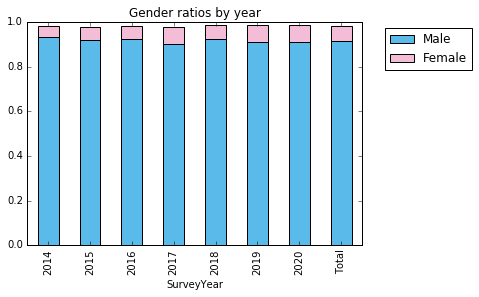

In [103]:
# 1. Gender. Replace every entry that contains multiple answers separated by ';' with 'Other'
col = 'Gender'
dfBig.loc[(dfBig[col].str.contains(';') == True).tolist(), col] = 'Other'

ax, _ = bars_by_year(dfBig, 'Gender', ntop=2, color=['#5ABAE9', '#F3BDD7'],
                  title='Gender ratios by year')

### Countries
Notably, up until 2015, the share of responses from the US decreases, and those from India grows. Afterwards, the chages are inconsistent, but overall, are pretty close to the average total. Moreover, most of the European countries were aggregated into a single answer in 2011-2013.

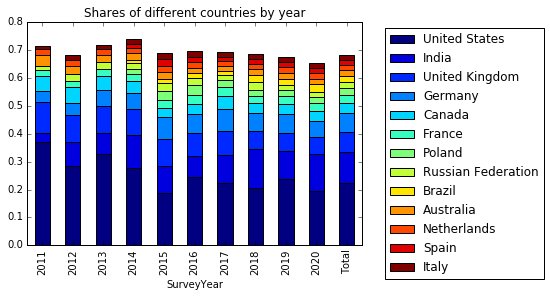

In [104]:
# 2. Plot top countries by year to get an idea, if there could be any biases in the data
ax, _ = bars_by_year(dfBig, 'Country', ntop=13,
                  title='Shares of different countries by year')

### Salaries
Up until 2017, the salaries were reported using ranges (brackets), and afterwars with actual numbers. We will convert all salaries to the range representation for consistency and make sure that the range definitions are the same across all years. Furthermore, in the 2017 dataset, all salaries seem to have been already converted from the national currencies to USD, except for those in GB pounds, which are suspiciosly round. Convert them using the Jan 2017 GBP/USD rate and copy all salaries to the SalaryUSD column for that year.

In [105]:
# 3. Convert Salaries to the numeric format
for col in ['Salary', 'SalaryUSD']:
    if np.issubdtype(dfBig[col].dtype, np.number):
        continue    # If it's been already converted
    if col == 'Salary':
        # Some of the salaries contain two or three decimal points that separate thouthands and millions, which prevents converting them to floats. Remove all decimal points (and the fractional decimal digits too).
        ser = dfBig[dfBig['Salary'].str.count('\.')>1]['Salary'].apply(lambda s : ''.join(s.split('.')[:-1]))     # Series of fixed salaries
        dfBig.loc[ser.index, 'Salary'] = ser
    dfBig[col] = pd.to_numeric(dfBig[col])

# Convert GBP to USD for 2017 data and copy all to SalaryUSD
GBP2USD = 1.234802    # on 31 Jan 2017, from https://www.ofx.com/en-nz/forex-news/historical-exchange-rates/
ser = dfBig.query("SurveyYear == 2017 & ~Salary.isnull() & Currency == 'British pounds sterling (£)'", engine='python')['Salary']
dfBig.loc[ser.index, 'SalaryUSD'] = ser*GBP2USD
ser = dfBig.query("SurveyYear == 2017 & ~Salary.isnull() & Currency != 'British pounds sterling (£)'", engine='python')['Salary']
dfBig.loc[ser.index, 'SalaryUSD'] = ser

# Regroup the salary brackets (in general, it is unnecessary, and one can work with overlapping brackets in different years, but let's do it anyway to simplify things...)
dfBig.replace({'SalaryBracketUSD':{'10,000 or less':'20,000 or less','10,000 to 20,000':'20,000 or less',
                                   '20,000 to 30,000':'20,000 to 40,000','30,000 to 40,000':'20,000 to 40,000',
                                   '40,000 to 50,000':'40,000 to 60,000', '50,000 to 60,000':'40,000 to 60,000',
                                   '60,000 to 70,000':'60,000 to 80,000', '70,000 to 80,000':'60,000 to 80,000',
                                   '80,000 to 90,000':'80,000 to 100,000', '90,000 to 100,000':'80,000 to 100,000',
                                   '100,000 to 110,000':'100,000 to 120,000', '110,000 to 120,000':'100,000 to 120,000',
                                   '120,000 to 130,000':'120,000 to 140,000', '130,000 to 140,000':'120,000 to 140,000',
                                   '140,000 to 150,000':'140,000 or more', '150,000 to 160,000':'140,000 or more',
                                   '140,000 to 160,000':'140,000 or more', '160,000 or more':'140,000 or more',
                                   '160,000 to 170,000':'140,000 or more', '170,000 to 180,000':'140,000 or more',
                                   '180,000 to 190,000':'140,000 or more', '190,000 to 200,000':'140,000 or more',
                                   '200,000 or more':'140,000 or more'}
              }, inplace=True)

# Assign the salaries from 2017-2020 to their corresponding brackets
dfBig.loc[dfBig.query("(SurveyYear >= 2017) & (SalaryUSD < 20000) ").index, 'SalaryBracketUSD'] = '20,000 or less'
dfBig.loc[dfBig.query("SurveyYear >= 2017 & 20000 <= SalaryUSD < 40000 ").index, 'SalaryBracketUSD'] = '20,000 to 40,000'
dfBig.loc[dfBig.query("SurveyYear >= 2017 & 40000 <= SalaryUSD < 60000 ").index, 'SalaryBracketUSD'] = '40,000 to 60,000'
dfBig.loc[dfBig.query("SurveyYear >= 2017 & 60000 <= SalaryUSD < 80000 ").index, 'SalaryBracketUSD'] = '60,000 to 80,000'
dfBig.loc[dfBig.query("SurveyYear >= 2017 & 80000 <= SalaryUSD < 100000 ").index, 'SalaryBracketUSD'] = '80,000 to 100,000'
dfBig.loc[dfBig.query("SurveyYear >= 2017 & 100000 <= SalaryUSD < 120000 ").index, 'SalaryBracketUSD'] = '100,000 to 120,000'
dfBig.loc[dfBig.query("SurveyYear >= 2017 & 120000 <= SalaryUSD < 140000 ").index, 'SalaryBracketUSD'] = '120,000 to 140,000'
dfBig.loc[dfBig.query("SurveyYear >= 2017 & SalaryUSD >= 140000 ").index, 'SalaryBracketUSD'] = '140,000 or more'

Median salary in the US in 2019 was $76726.35.


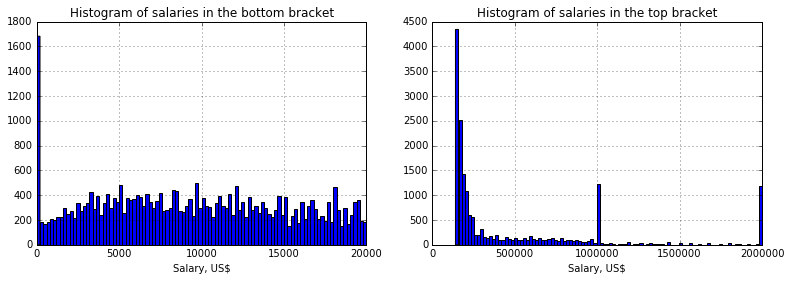

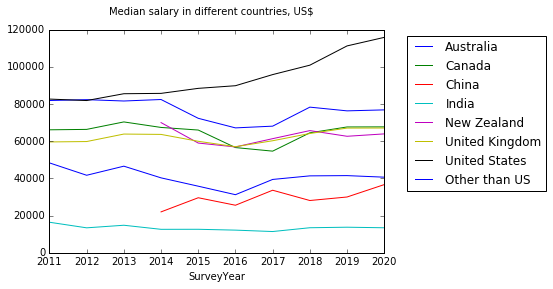

In [106]:
# Let's take a quick look at the resulting SalaryBracketUSD column
col = 'SalaryBracketUSD'

# # Display the counts
# count_by_year = dfBig.groupby('SurveyYear')[col].value_counts().unstack(level='SurveyYear')   # A series of counted values with the top level in Multiindex corresponding to the Survey year, unstacked
# with pd.option_context('display.max_rows', 100, 'display.max_columns', None):
#     display.display(count_by_year)

fig, ax = plt.subplots(1, 2, figsize=(13, 4))
dfBig.query("SalaryBracketUSD == '20,000 or less'")['SalaryUSD'].hist(bins=100, ax=ax[0])
dfBig.query("SalaryBracketUSD == '140,000 or more'")['SalaryUSD'].hist(bins=100, ax=ax[1])
ax[0].set_title('Histogram of salaries in the bottom bracket')
ax[1].set_title('Histogram of salaries in the top bracket')
ax[0].set_xlabel('Salary, US$')
ax[1].set_xlabel('Salary, US$')
# ax[1].set_yscale('log')

# Disproportionally many people seem to have their salaries set to 1000000 or 2000000; these are likely erroneous entries, so we'll just remove them all.
# Similarly remove all salaries that are set to (or very close to) 0
dfBig.loc[dfBig.query("SalaryUSD == 1000000 | SalaryUSD == 2000000 | SalaryUSD < 10").index,
          ['SalaryUSD', 'SalaryBracketUSD']] = [np.nan, 'Rather not say']

# Instead of actual brackets we will be working with median salaries computed based on samples from the data. The following function does this.
def median_salary(ser):
    """
        Computes the median salary by merging multiple salary brackets together.
        The distribution of salaries in each bracket is assumed to be uniform,
        except for the last one, where it is modelledas a long-tailed (Paretto)
        distribution with x_m= and alpha= .
        
        INPUTS:
            ser - a series of SalaryBracketUSD values.
        OUTPUT:
            a number representing the median salary in the given brackets.
    """
    mapping_BracketMax = {'20,000 or less':20000, '20,000 to 40,000':40000, '40,000 to 60,000':60000,
                          '60,000 to 80,000':80000, '80,000 to 100,000':100000, '100,000 to 120,000':120000,
                          '120,000 to 140,000':140000, '140,000 or more':240000} # Maps a salary bracket to its highest value
    counts = pd.Series(data=0, index=[0]+sorted(mapping_BracketMax.values()) )   # An empty Series to hold the counts of the number of different brackets
    counts.update(ser.value_counts().rename(index=mapping_BracketMax))       # Number of occurences of each bracket with a certain maximum value
    
    cumul_counts = counts.cumsum() / counts.sum()    # Cummulative distribution of the salaries
    
    # Interpolate the distribution and find which salary corresponds to the 0.5 level (for this, treat the counts as an independent variable, and the salary as the dependent variable)
    return np.interp(0.5, xp=cumul_counts.values, fp=cumul_counts.index)

# For example:
print('Median salary in the US in 2019 was ${:.2f}.'.format(median_salary(dfBig.query("Country == 'United States' | SurveyYear == 2019")['SalaryBracketUSD']) ) )

# In fact, the salary of US repondents seem to have the most monsistency over the years. Apparently, there are a few factors at play: more data, no currency conversion, minimal risk of errors.
#We will aim to use only US data when analysing trends in salary
fig = plt.figure()
dfBig.query("Country in ['United States', 'United Kingdom', 'Canada', 'Australia', 'New Zealand', 'India', 'China']").\
        groupby(['Country', 'SurveyYear'])['SalaryBracketUSD'].apply(median_salary).unstack(level='Country').plot(ax=fig.gca())
dfBig.query("Country != 'United States'").groupby(['SurveyYear'])['SalaryBracketUSD'].apply(median_salary).plot(label='Other than US', ax=fig.gca())
fig.suptitle('Median salary in different countries, US$')
fig.gca().legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))

### YearsProgram
The number of years someone has been programming is reported inconsistently across the dataset. we will merge the answers into larger brackets to make working with this data easier.

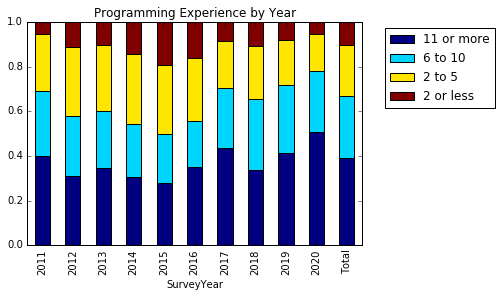

In [107]:
# 4. Define a new column 'YearsProgramBracket' and aggregate the values from the 'YearsProgram' column
mapping = {'0 to 2':'2 or less', '0 to 1':'2 or less','1 to 2':'2 or less','1':'2 or less','2':'2 or less',
           '2 to 5':'2 to 5','2 to 3':'2 to 5','3 to 4':'2 to 5','4 to 5':'2 to 5','3':'2 to 5','4':'2 to 5','5':'2 to 5','3 to 5':'2 to 5',
           '6 to 10':'6 to 10','5 to 6':'6 to 10','6 to 7':'6 to 10','9 to 11':'6 to 10','7 to 8':'6 to 10','8 to 9':'6 to 10','9 to 10':'6 to 10','6 to 8':'6 to 10','6':'6 to 10','7':'6 to 10','8':'6 to 10','9':'6 to 10','10':'6 to 10',
           '11':'11 or more', '12 to 14':'11 or more', '20 or more':'11 or more'}
dfBig['YearsProgramBracket'] = dfBig['YearsProgram'].map(lambda x: replace_choices(x, mapping) if x in mapping.keys() else '11 or more' )

dfBig['YearsProgramBracket'].value_counts()

ax, _ = bars_by_year(dfBig, 'YearsProgramBracket',
                  title='Programming Experience by Year')

### Languages, Databases, Frameworks, and Other Technologies
Several questions ask about technologies and languages someone has been working with, but the answers are not consistent across the years (e.g. some technologies may appear both in HaveWorkedLanguages and HaveWorkedDatabase columns). Need to reassign them to separate columns to make the data consistent.

In [108]:
# Reassigning different technologies to separate groups. Warning! This cell takes long to compute.
dfDev = dfBig.sample(frac=0.13, random_state=42)      # Use a smaller part of the dataframe to find the assignment of technlogies to different groups
techGroups = ['Collab', 'Database', 'Platform', 'Framework','Language', 'Misc']    # List of all possible techgroups to whic technologies can be assigned. In the database, there are corresponding columns 'HaveWorkedXXX' and 'WantWorkXXX' for each techGroup XXX, e.g. 'HaveWorkedLanguage'

# # # Count how often each technology appears in different groups (first expand the multichoice column and then count the number of boolean True in each resulting column for different technologies)
dfCount = pd.DataFrame().join( [expand_multichoice(dfDev['HaveWorked'+tg].append(dfDev['WantWork'+tg], ignore_index=True).dropna()).\
                                sum().fillna(0).rename(tg) for tg in techGroups], how='outer').fillna(0)
dfCount['AssignedTechGroup'] = dfCount.idxmax(axis=1)   # Find the techGroup corresponding to the maximum number of entries for each technology

# Overwrite some assignments to TechGroups, if desired
serManual = pd.Series({'jQuery':'Framework', 'iOS':'Platform', 'Xamarin':'Framework', 'WordPress':'Platform',
           'Windows Phone':'Platform', 'Torch/PyTorch':'Misc', 'TensorFlow':'Misc', 'Spark':'Framework',
           'SharePoint':'Platform', 'Salesforce':'Platform', 'SQL Server':'Database', 'Redis':'Database',
           'React/React.js':'Framework', 'Node.js':'Framework', 'MongoDB':'Database', 'Microsoft Azure':'Platform',
           'Hadoop':'Framework', 'Firebase':'Platform', 'Drupal':'Framework', 'Cordova':'Framework',
           'Cloud (AWS, GAE, Azure, etc.)':'Platform', 'Cassandra':'Database', '.NET / .NET Core':'Framework',
           'Android':'Platform', 'Angular/Angular.js':'Framework', 'Arduino / Raspberry Pi':'Platform'},
                      name='AssignedTechGroup')
dfCount.update(serManual)

print('\nOccurence of each technology in different groups (originally), \nalong with the assigned TechGroup in the last column:')
display.display(dfCount.head(10))

# Create a new dataframe with separate columns for each technology, and differentiate between HaveWorked/WantWork
dfHaveWant = pd.DataFrame().join([join_entries(dfBig, [pref+col for col in techGroups]).rename(pref)
                                  for pref in ['HaveWorked', 'WantWork'] ], how='outer')      # Columns with all listed technologies
dfHaveWant = expand_multichoice(dfHaveWant, 'HaveWorked', rename=True)
dfHaveWant = expand_multichoice(dfHaveWant, 'WantWork', rename=True)
dfHaveWant.replace({(pref, tech):{True:tech, False:np.nan}
                    for pref in ['HaveWorked', 'WantWork'] for tech in dfCount.index}, inplace=True)

# Merge together different technologies from the same techGroup
_temp = []    # A temporary array to hold the merged series
for group in techGroups:
    print('Merging {}...'.format(group))
    _temp.extend( [join_entries(dfHaveWant, [(pref, tech) for tech in dfCount.query("AssignedTechGroup == @group").index
                                             if (pref, tech) in dfHaveWant.columns]).rename(pref+group)
                   for pref in ['HaveWorked', 'WantWork'] ] )
dfHaveWantMerged = pd.DataFrame().join(_temp, how='outer')

# Update the original dataframe (drop the columns and then join the remaining datafarme with the new ones)
print('\nUpdating the dfBig dataframe...')
dfBig.drop(labels=[pref+group for pref in ['HaveWorked', 'WantWork'] for group in techGroups], axis=1, inplace=True)
dfBig = dfBig.join(dfHaveWantMerged, how='outer')


Occurence of each technology in different groups (originally), 
along with the assigned TechGroup in the last column:


,Collab,Database,Platform,Framework,Language,Misc,AssignedTechGroup
.NET / .NET Core,0.0,0.0,0.0,5768.0,0.0,9633.0,Framework
ASP.NET / ASP.NET Core,0.0,0.0,0.0,6684.0,0.0,0.0,Framework
Amazon DynamoDB,0.0,3837.0,0.0,0.0,0.0,0.0,Database
Amazon Echo,0.0,0.0,1018.0,0.0,0.0,0.0,Platform
Amazon RDS/Aurora,0.0,1120.0,0.0,0.0,0.0,0.0,Database
Amazon Redshift,0.0,643.0,0.0,0.0,0.0,0.0,Database
Amazon Web Services (AWS),0.0,0.0,17455.0,0.0,0.0,0.0,Platform
Android,0.0,0.0,17926.0,0.0,4074.0,0.0,Platform
Angular/Angular.js,0.0,0.0,0.0,16009.0,3528.0,0.0,Framework
Ansible,0.0,0.0,0.0,0.0,0.0,2411.0,Misc


Merging Collab...
Merging Database...
Merging Platform...
Merging Framework...
Merging Language...
Merging Misc...

Updating the dfBig dataframe...


In [109]:
# Group several minor languages into the 'Other' (or a related) category

# col = 'HaveWorkedDatabase'
# # Find which multiple choice answers overlap with each other (i.e. present simultaneously in the database entries), and thus are good candidates to be merged
# ser = dfBig[col].dropna()   # We'll be working in a separate series
# choices = sorted(list( set(map(str.strip, set(';'.join(ser.values).split(';') ) )) ))      # All possible (individual) choices in the answers to the multiple choice question
# dfExp = pd.DataFrame().join([ser.str.contains(ch, regex=False).rename(ch).to_frame() for ch in choices], how='outer')    # An expanded datafrane with columns corresponding to every choice
# print(choices)
# # Plot the correlation matrix
# fig = plt.figure(figsize=(13, 10))
# sn.heatmap(dfExp.corr(), ax=fig.gca(), vmin=0, vmax=0.4, cmap='rocket_r')
# fig.show()

for col in ['HaveWorkedLanguage', 'WantWorkLanguage']:
    mapping = {'Clojure':'Lisp', 'Common Lisp':'Lisp', 'Swift':'Objective-C','React/React.js':'JavaScript',
               'CoffeeScript':'Other', 'Dart':'Other', 'Groovy':'Java','Hack':'PHP', 'TypeScript':'JavaScript',
               'Cobol':'Other', 'Elixir':'Other', 'Erlang':'Other', 'Delphi/Object Pascal':'Other', 'Rust':'C++',
               'Ocaml':'Other','Haskell':'Other','Julia':'Other','Smalltalk':'Other', 'WebAssembly':'Other',
               'LAMP':'Other', 'Kotlin':'Other', 'Lua':'Other', 'None':'', 'F#':'Other'}
    dfBig[col] = dfBig[col].map(lambda x: replace_choices(x, mapping) )

### Developer Types
The DeveloperType column still has too many options; we'll siplify it here to make more manageable. Moreover, we will store the specific type of Web developers in a separate column, as done in the 2017 dataset.

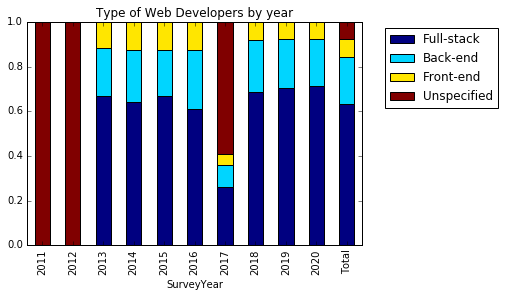

In [110]:
#
col = 'DeveloperType'

# Store the type of web developer in a separate column
dfBig.loc[dfBig['DeveloperType'].str.contains('Web developer', na=False), 'WebDeveloperType'] = 'Unspecified'
ser_front = dfBig['DeveloperType'].str.contains('Developer, front-end', na=False)
ser_back = dfBig['DeveloperType'].str.contains('Developer, back-end', na=False)
ser_full = dfBig['DeveloperType'].str.contains('Developer, full-stack', na=False)
dfBig.loc[ser_front, 'WebDeveloperType'] = 'Front-end'
dfBig.loc[ser_back, 'WebDeveloperType'] = 'Back-end'
dfBig.loc[(ser_front & ser_back)|ser_full, 'WebDeveloperType'] = 'Full-stack'

ax, _ = bars_by_year(dfBig, 'WebDeveloperType', ntop=13,
                  title='Type of Web Developers by year')

# # Find which multiple choice answers overlap with each other (i.e. present simultaneously in the database entries), and thus are good candidates to be merged
# ser = dfBig[col].dropna()   # We'll be working in a separate series
# choices = list_choices(ser)      # All possible (individual) choices in the answers to the multiple choice question
# dfExp = pd.DataFrame().join([ser.str.contains(ch).rename(ch).to_frame() for ch in choices], how='outer')    # An expanded datafrane with columns corresponding to every choice
# # Plot the correlation matrix
# fig = plt.figure(figsize=(13, 10))
# sn.heatmap(dfExp.corr(), ax=fig.gca(), vmin=0, vmax=0.4, cmap='rocket_r')
# fig.show()
# # It can be seen that, for example choices for System Administrator and Database Administrator occur together quite often, and thus can be merged with minimal loss of information. Similarly for few other cases.

# Group some of the choioces together
mapping = {'Engineer, data':'Data scientist, analyst, or engineer', 'Data or business analyst':'Data scientist, analyst, or engineer', 'Data scientist, incl. ML':'Data scientist, analyst, or engineer','Developer with a statistics or mathematics background':'Data scientist, analyst, or engineer',
           'Developer, full-stack':'Web developer','Developer, front-end':'Web developer','Developer, back-end':'Web developer',
           'Systems Analyst':'DB/System administrator or engineer', 'Database administrator':'DB/System administrator or engineer', 'Systems administrator':'DB/System administrator or engineer',
           'Senior executive/VP':'Manager, marketing, or sales','Growth hacker':'Manager, marketing, or sales','Engineering manager':'Manager, marketing, or sales','Marketing or sales professional':'Manager, marketing, or sales','Product manager':'Manager, marketing, or sales',
           'Engineer, site reliability':'DevOps specialist',
           'Kernel / Driver Developer':'Other','Server Programmer':'Other',
           'I don\'t work in tech':'Other'}
dfBig[col] = dfBig[col].map(lambda x: replace_choices(x, mapping) )


### Education

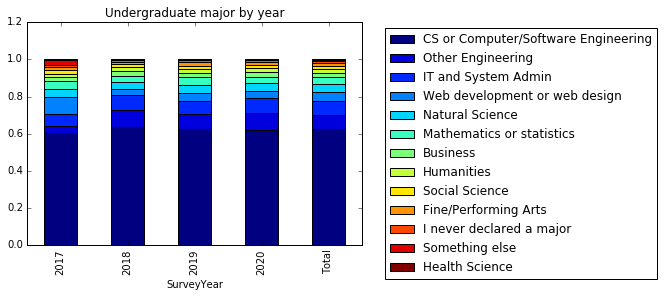

In [111]:
# 
ax, _ = bars_by_year(dfBig, 'MajorUndergrad', ntop=13,
                  title='Undergraduate major by year')

### Job Satisfaction
Fusing different JobSatisfaction answers across the years is one of the most challenging tasks. First, in different years, the same question was formulated slightly diffrently, and second, it had different number of different answer options. A few of the options have been replaced already during the cleaning (e.g. 'I love my job' became 'Extremely satisfied' for consistency), but some answers can not be simply mapped across the years. For example, it is apparent that 'Moderately satisfied' in 2018 in the respondednt perception sits somewhere in between 'Very satisfied' and 'Slightly satisfied'.

SurveyYear,2015,2016,2018,2019,2020,Total
JobSatisfaction,,,,,,
Extremely dissatisfied,NaN,NaN,0.035828,NaN,NaN,0.010304
Very dissatisfied,0.019058,0.021129,NaN,0.068420,0.082887,0.040438
Moderately dissatisfied,NaN,NaN,0.091200,NaN,NaN,0.026228
Slightly dissatisfied,0.097788,0.114445,0.101868,0.151462,0.157632,0.128733
Neither satisfied nor dissatisfied,0.110910,0.112010,0.071684,0.122838,0.127959,0.106523
Slightly satisfied,0.408648,0.416309,0.144523,0.341001,0.308227,0.295167
Moderately satisfied,NaN,NaN,0.375383,NaN,NaN,0.107955
Very satisfied,0.363597,0.336107,NaN,0.316279,0.323295,0.233026
Extremely satisfied,NaN,NaN,0.179514,NaN,NaN,0.051626


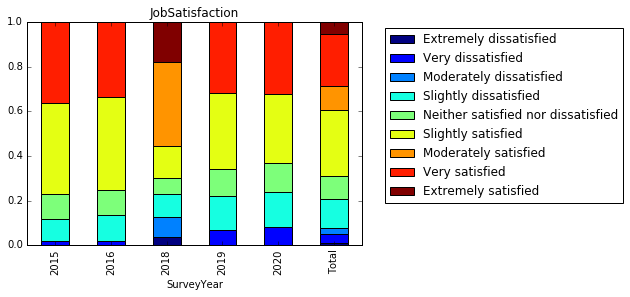

In [112]:
#
col = 'JobSatisfaction'
sortOrder = ['Extremely dissatisfied', 'Very dissatisfied', 'Moderately dissatisfied', 'Slightly dissatisfied',
             'Neither satisfied nor dissatisfied',
             'Slightly satisfied', 'Moderately satisfied','Very satisfied', 'Extremely satisfied'
            ]
ax, df = bars_by_year(dfBig.query("SurveyYear in [2015, 2016, 2018, 2019, 2020]"), col, ntop=50,
                  sortkey = lambda x : sortOrder.index(x) if x in sortOrder else int(x))

display.display(df)

On top of this, in 2017, the answers were collected on a numerical scale from 0 (least satisfied) to 10 (most satisfied). We will adopt this scale, and attempt to convert the answers in other years to their approximate ranges such that the trends are more or less smooth across the years. Overall, it looks like there is downwards trend in job satisfaction, at least if comparing 2016 and 2019.

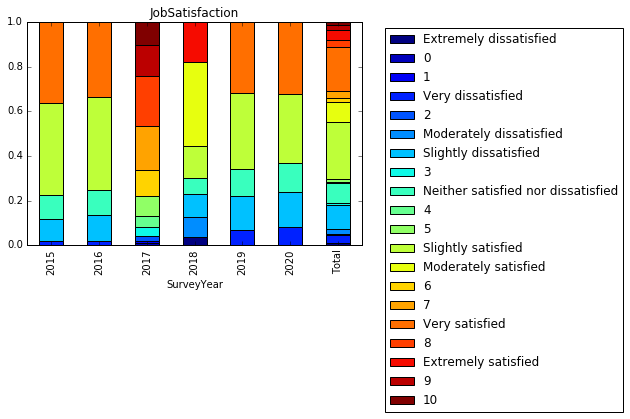

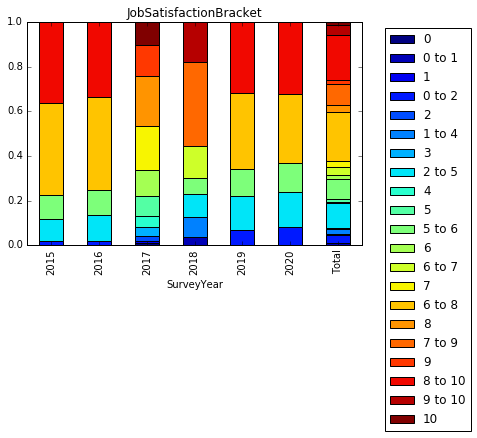

In [113]:
#
ax, _ = bars_by_year(dfBig, col, ntop=50,
                  sortkey = lambda x : sortOrder.index(x) if x in sortOrder else int(x))

# Replace most of the entries in all years
dfBig['JobSatisfactionBracket'] = dfBig['JobSatisfaction'].replace({'Very satisfied' : '8 to 10', 'Extremely satisfied' : '9 to 10',
                                  'Moderately satisfied' : '7 to 9', 'Neither satisfied nor dissatisfied': '5 to 6',
                                  'Extremely dissatisfied' : '0 to 1', 'Very dissatisfied' : '0 to 2', 'Moderately dissatisfied' : '1 to 4', 'Slightly dissatisfied' : '2 to 5'})

# Replace 'Slightly satisfied' in 2018 and non-2018 separately
dfBig.loc[(dfBig.SurveyYear != 2018) & (dfBig.JobSatisfactionBracket == 'Slightly satisfied'), 'JobSatisfactionBracket'] = '6 to 8'
dfBig.loc[(dfBig.SurveyYear == 2018) & (dfBig.JobSatisfactionBracket == 'Slightly satisfied'), 'JobSatisfactionBracket'] = '6 to 7'

ax, _ = bars_by_year(dfBig, 'JobSatisfactionBracket', ntop=50,
             sortkey = lambda x : np.mean(parse_bracket(x)))

Now we can use these brackets to compute an approximate median job satiscation score by year.

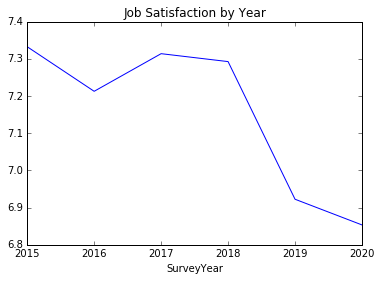

In [144]:
df = dfBig.groupby('SurveyYear').JobSatisfactionBracket.value_counts().unstack('SurveyYear')

# Plot the aggregated medians
ax = df.agg(agg_median).plot(title='Job Satisfaction by Year')
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

In [115]:
# Save the updated (final) dataframe
dfBig.to_csv(path.join('data', 'data_final.csv'), index=False)

# Part 4. Analysis and Visualisation

Finally, in this part, we will analyse the data, ask some questions about and try to answer and visualize them.

In [3]:
# Read the final dataframe for analysis
dfBig = pd.read_csv(path.join('data', 'data_final.csv'), low_memory=False)

In [4]:
# Expand the columns that contain answers to multichoice questions using one-hot encoding; use only not-NaN entries (which can be different in each column)
dfExp_lng = expand_multichoice(dfBig[['SurveyYear', 'HaveWorkedLanguage']].dropna(), 'HaveWorkedLanguage')
dfExp_dev = expand_multichoice(dfBig[['SurveyYear', 'DeveloperType']].dropna(), 'DeveloperType')
# Remove the response 'Other' if specific developer type(s) has been chosen
dfExp_dev.loc[ dfExp_dev.loc[:, dfExp_dev.columns != 'SurveyYear'].sum(axis=1)>1, 'Other'] = False

# # Check how many choices have been selected
# dfExp_dev['NumSelected'] = dfExp_dev.loc[:, list_choices(dfBig['DeveloperType'])].sum(axis=1)
# dfExp_dev.groupby(['SurveyYear', 'NumSelected'])['NumSelected'].count().unstack('SurveyYear')

# dfExp_lng['NumSelected'] = dfExp_lng.loc[:, list_choices(dfBig['HaveWorkedLanguage'])].sum(axis=1)
# dfExp_lng.groupby(['SurveyYear', 'NumSelected'])['NumSelected'].count().unstack('SurveyYear')

# Remove entries with too many choices selected
dfExp_lng = dfExp_lng.loc[dfExp_lng.loc[:, list_choices(dfBig['HaveWorkedLanguage'])].sum(axis=1) < 16, :]
dfExp_dev = dfExp_dev.loc[dfExp_dev.loc[:, list_choices(dfBig['DeveloperType'])].sum(axis=1) < 8, :]

### Popularity of different languages by year
First we look at the most straightforward question about how the popularity of different programming languages (and possibly other technologies) have changed over the years.

First, we will only look at the programming languages that someone have worked with. To make things a bit sinpler, we select only the top nine most popular languages, which are present in the answers across all years.

SurveyYear,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
HaveWorkedLanguage,,,,,,,,,,
Assembly,0,0,0,0,0,0,1823,5760,5833,3553
Bash/Shell,0,0,0,0,0,0,0,31172,31991,18980
C,741,1484,1436,1174,3612,7678,6974,18042,18017,12487
C#,1352,2468,3027,2378,6949,15283,12476,26954,27097,18041
C++,740,1526,1696,1418,4891,9822,8379,20819,22044,15324
Go,0,0,0,0,462,1547,1557,5532,7201,5038
HTML/CSS,1356,3140,0,0,0,0,0,54532,55466,36181
Java,861,2348,3020,2479,8219,17942,14701,35934,35917,23074
JavaScript,1419,3127,4735,3783,11962,27385,23099,55373,60582,39904


The selected top languages are: 
 ['C', 'C#', 'C++', 'Python', 'Java', 'JavaScript', 'PHP', 'Ruby', 'SQL']
The minor programming languages are: 
 ['Assembly', 'Go', 'Lisp', 'Matlab', 'Objective-C', 'Other', 'Perl', 'R', 'Scala', 'VB/VB.NET']


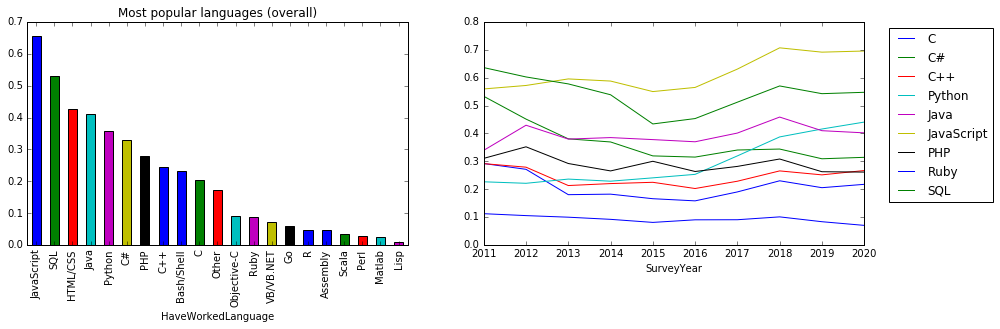

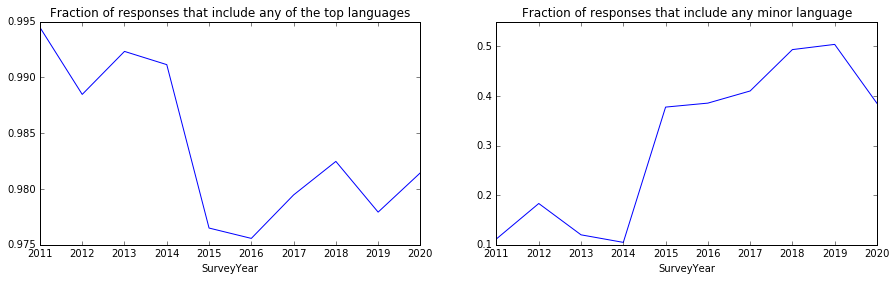

In [5]:
# Display the occurence of different languages in the multiple choice answers across the years
dfCnt = counts_by_group(dfBig, 'HaveWorkedLanguage')

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display.display(dfCnt)
    
# Plot most popular languages across all years, disreagarding repeats and missing values
fig, ax = plt.subplots(1,2,figsize=(15,4))
(dfCnt.sum(axis=1).drop('TOTAL') / dfCnt.sum(axis=1).TOTAL).sort_values(ascending=False).\
                   plot(kind='bar', title='Most popular languages (overall)', ax=ax[0])

# Select only the most popular/interesting languages and technologies
allLanguages = list_choices(dfBig.HaveWorkedLanguage)    # All possible programming languages in the dataset
majorLanguages = ['C', 'C#', 'C++', 'Python', 'Java', 'JavaScript', 'PHP', 'Ruby', 'SQL', 'HTML/CSS', 'Bash/Shell']
minorLanguages = sorted(list(set(allLanguages).difference(majorLanguages)))
topLanguages = ['C', 'C#', 'C++', 'Python', 'Java', 'JavaScript', 'PHP', 'Ruby', 'SQL']    # Languages present in every year
print('The selected top languages are: \n', topLanguages)
print('The minor programming languages are: \n', minorLanguages)

dfRatios = dfCnt.drop('TOTAL').replace({0:np.nan}) / dfCnt.loc['TOTAL', :]
dfRatios.T.plot(y=topLanguages, ax=ax[1])
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%d'))

# What fraction of responses have any language other than one in topLanguages
fig, ax = plt.subplots(1,2,figsize=(15,4))
df = expand_multichoice(dfBig[['SurveyYear', 'HaveWorkedLanguage']].dropna(), 'HaveWorkedLanguage')
df['anyTopLang'] = df[topLanguages].any(axis=1)
df['anyMinorLang'] = df[minorLanguages].any(axis=1)
df.groupby('SurveyYear')['anyTopLang'].mean().plot(title = 'Fraction of responses that include any of the top languages', ax=ax[0])
df.groupby('SurveyYear')['anyMinorLang'].mean().plot(title = 'Fraction of responses that include any minor language', ax=ax[1])
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%d'))

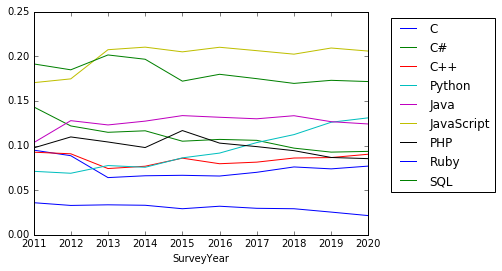

In [6]:
# Rank the languages using Page Rank

def _pagerank_bool(df):
    """
    Computes pagerank cores for columns of the dataframe df; can be used with pd.DataFrame.groupby.
    INPUT: df - A dataframe with columns using 0/1 encoding, nulls are not allowed
    OUTPUT: a series of pagerank values.
    """
    # Compute the probability transition matrix
    CPT = (df.T.dot(df)).astype('float') / df.sum()       # compute the conditional probabilities, CPT_i,j=P(i|j); if sum=0, the column will be set to nulls and dropped later
    np.fill_diagonal(CPT.values, df.sum()/df.shape[0])     # Set the diagonal to the probabilities of knowing only a single language
    CPT = (CPT / CPT.sum()).dropna(axis=1)        # Normalize the columns (drop missing columns and then drop the corresponding rows)
    CPT = CPT.loc[CPT.columns, :]                 # Drop the rows corresponding to missing columns
#     display.display(CPT)

    # Iterative solution
    R0 = df[CPT.columns].sum()
    R0 /= R0.sum()             # The inital rank vector (distribution of choices ignoring repeats)
    for i in range(50):
    #     print(i, R0.T)
        R = CPT.dot(R0).squeeze()
        
        # Check for convergence
        if np.linalg.norm(R-R0) < 1e-05:
            break
        
        R0 = R      # Update the starting vector

# #     print(R0.sort_values(ascending=False))
# #     print(R0.sum())
    
#     # Closed-form solution using eigendecomposition (doesn't work if CPT graph has sink nodes, in which case, it needs some damping factor)
#     # Find the leading eigenvector and turn it into series
#     w, v = np.linalg.eig(CPT)
#     R = pd.Series(v[:, np.argmax(w)], index=CPT.index, name='PageRank')
#     R /= R.sum()
#     R = R.to_frame().T

    R = R.reindex(index=df.columns)     # Add missing index values (if any) to match the columns in the original df
    
    return R

df = dfExp_lng.replace({True:1, False:0})

# print(_pagerank_bool(df.query("SurveyYear == '2020'").drop(columns='SurveyYear')).squeeze().sort_values())

dfRanks = df.groupby('SurveyYear')[topLanguages].apply(lambda x : _pagerank_bool(x))

ax = dfRanks.plot()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# dfRanks

### Types of developers

Split the respondents into four categories: (1) web-developers (incl. Designers), (2) other developers that haven't selected the options of Web-developer/designer, (3) developers who selected the option of web-developer/designer and some other technical developer role, (4) non-developer types (management, researchers).

In [7]:
# #
# dfCnt = counts_by_group(dfBig, 'DeveloperType')

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display.display(dfCnt)
    
dfCnt = dfExp_dev.groupby('SurveyYear').sum().astype('int').T
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display.display(dfCnt)

SurveyYear,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
DB/System administrator or engineer,162,287,288,218,463,1003,6893,17558,13304,7911
"Data scientist, analyst, or engineer",0,0,0,0,1197,3107,6236,11865,13076,8242
Designer,0,0,0,0,150,333,1325,11526,8504,4860
DevOps specialist,0,0,0,123,322,1074,3916,9185,9510,6340
"Developer, QA or test",0,0,0,0,164,379,1162,5769,5678,3521
"Developer, desktop or enterprise applications",419,774,1361,984,2334,4861,10313,15303,16477,11240
"Developer, embedded applications or devices",115,326,210,185,609,1268,3239,4462,6588,4326
"Developer, game or graphics",0,0,0,0,164,293,1631,4325,3995,2473
"Developer, mobile",0,0,631,579,1900,4139,8203,18298,13922,8974
"Educator, reseacher, or scientist",0,0,0,0,0,0,0,3389,9788,6014


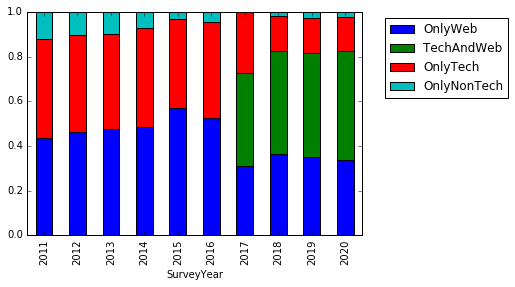

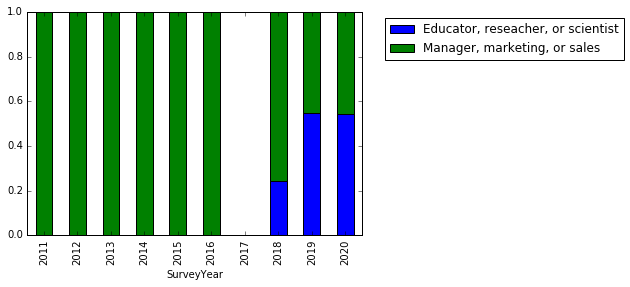

In [8]:
#
df = dfExp_dev    # !!! The df is not copied! Will mofidy dfExp_dev inplace !!!
allDevTypes = list_choices(dfBig['DeveloperType'])
nonTechTypes = ['Educator, reseacher, or scientist', 'Manager, marketing, or sales']    # Non-developers
nonWebTypes = sorted(list(set(allDevTypes).difference(nonTechTypes+['Web developer', 'Designer'])))   # Other developers/technical (non-Web)

df['OnlyWeb'] = df[['Web developer', 'Designer']].any(axis=1) & (~df[nonWebTypes].any(axis=1))
df['TechAndWeb'] = df[['Web developer', 'Designer']].any(axis=1) & df[nonWebTypes].any(axis=1)
df['OnlyTech'] = df[nonWebTypes].any(axis=1) & (~df[['Web developer', 'Designer']].any(axis=1))
df['OnlyNonTech'] = df[nonTechTypes].any(axis=1) & (~df[nonWebTypes+['Web developer', 'Designer']].any(axis=1))

dfCnt = df.drop(columns=allDevTypes).groupby('SurveyYear').sum()
dfCnt = dfCnt.divide(dfCnt.sum(axis=1), axis=0)
ax = dfCnt.plot(kind='bar', stacked=True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

dfCnt = df.groupby('SurveyYear')[nonTechTypes].sum()
dfCnt = dfCnt.divide(dfCnt.sum(axis=1), axis=0)
ax = dfCnt.plot(kind='bar', stacked=True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

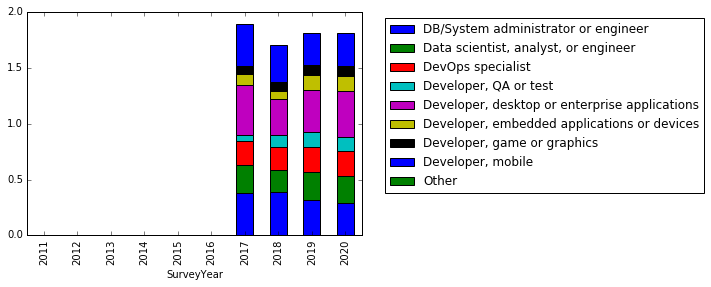

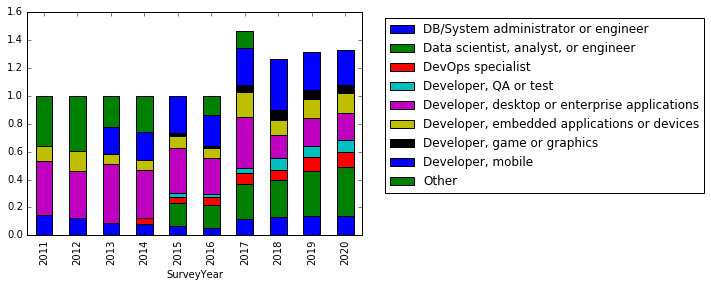

In [9]:
#
dfCnt = df.loc[df['TechAndWeb'], ['SurveyYear']+nonWebTypes].groupby('SurveyYear').sum()
dfCnt = dfCnt.divide(df.groupby('SurveyYear')['TechAndWeb'].sum(), axis=0)

ax = dfCnt.plot(kind='bar', stacked=True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

dfCnt = df.loc[df['OnlyTech'], ['SurveyYear']+nonWebTypes].groupby('SurveyYear').sum()
dfCnt = dfCnt.divide(df.groupby('SurveyYear')['OnlyTech'].sum(), axis=0)

ax = dfCnt.plot(kind='bar', stacked=True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# df.loc[df.Other, :]

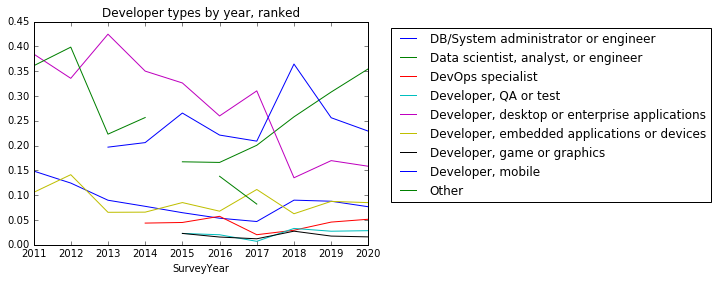

In [10]:
# df = dfExp_dev.replace({True:1, False:0})

# print(_pagerank_bool(df.query("SurveyYear == '2015'")[nonWebTypes] ) )
dfRanks = df.loc[df['OnlyTech'], ['SurveyYear']+nonWebTypes]\
          .groupby('SurveyYear')[nonWebTypes].apply(lambda x : _pagerank_bool(x))

ax = dfRanks.plot(title='Developer types by year, ranked')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# dfRanks

In [11]:
# Save the dataframes to analyse them externally, e.g. in Tableau
cols_to_save = ['SurveyYear','Country', 'JobSeeking', 'SalaryBracketUSD',
               'OperatingSystem', 'AgeBracket','JobSatisfactionBracket','Gender']

# dfExp = dfExp_lng.join(dfExp_dev.drop(columns=['SurveyYear', 'Other']), how='inner')
# dfExp_lng.to_csv(path.join('data', '_dfExp_lng.csv'))
# dfExp_dev.to_csv(path.join('data', '_dfExp_dev.csv'))
# dfBig[cols_to_save].to_csv(path.join('data', '_dfSel.csv'))  # Save the selected columns
dfSel = dfBig[cols_to_save].join([dfExp_lng.rename(columns={'Other':'OtherLanguage'}).drop(columns='SurveyYear'),
                                  dfExp_dev.rename(columns={'Other':'OtherDeveloper'}).drop(columns='SurveyYear')],
                                 how='outer')
dfSel.sample(frac=0.25).to_csv(path.join('data', '_dfMerged.csv'))

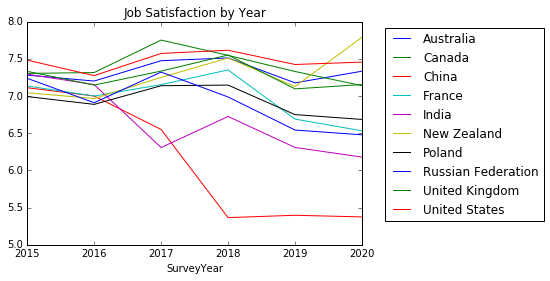

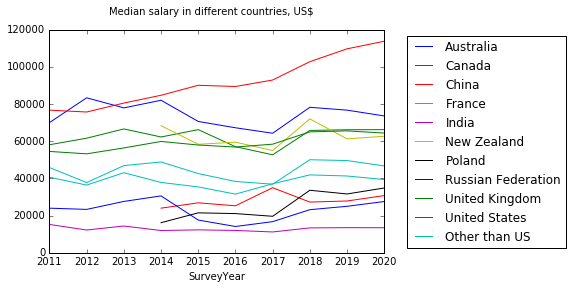

In [175]:
df0 = dfBig.iloc[df[df['OnlyWeb']].index, :]

df1 = df0.query("Country in ['United States', 'United Kingdom', 'Canada', 'Australia', 'France', 'Poland', 'Russian Federation', 'New Zealand', 'India', 'China']").\
        groupby(['Country', 'SurveyYear']).JobSatisfactionBracket.value_counts().unstack(['Country', 'SurveyYear'])
    
# Plot the aggregated medians of Job Satisfaction
ax = df1.agg(agg_median).unstack(level='Country').plot(title='Job Satisfaction by Year')
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

def median_salary(ser):
    """
        Computes the median salary by merging multiple salary brackets together.
        The distribution of salaries in each bracket is assumed to be uniform,
        except for the last one, where it is modelledas a long-tailed (Paretto)
        distribution with x_m= and alpha= .
        
        INPUTS:
            ser - a series of SalaryBracketUSD values.
        OUTPUT:
            a number representing the median salary in the given brackets.
    """
    mapping_BracketMax = {'20,000 or less':20000, '20,000 to 40,000':40000, '40,000 to 60,000':60000,
                          '60,000 to 80,000':80000, '80,000 to 100,000':100000, '100,000 to 120,000':120000,
                          '120,000 to 140,000':140000, '140,000 or more':240000} # Maps a salary bracket to its highest value
    counts = pd.Series(data=0, index=[0]+sorted(mapping_BracketMax.values()) )   # An empty Series to hold the counts of the number of different brackets
    counts.update(ser.value_counts().rename(index=mapping_BracketMax))       # Number of occurences of each bracket with a certain maximum value
    
    cumul_counts = counts.cumsum() / counts.sum()    # Cummulative distribution of the salaries
    
    # Interpolate the distribution and find which salary corresponds to the 0.5 level (for this, treat the counts as an independent variable, and the salary as the dependent variable)
    return np.interp(0.5, xp=cumul_counts.values, fp=cumul_counts.index)

# Plot median salaries
fig = plt.figure()
df0.query("Country in ['United States', 'United Kingdom', 'Canada', 'Australia', 'France', 'Poland', 'Russian Federation', 'New Zealand', 'India', 'China']").\
        groupby(['Country', 'SurveyYear'])['SalaryBracketUSD'].apply(median_salary).unstack(level='Country').plot(ax=fig.gca())
df0.query("Country != 'United States'").groupby(['SurveyYear'])['SalaryBracketUSD'].apply(median_salary).plot(label='Other than US', ax=fig.gca())
fig.suptitle('Median salary in different countries, US$')
fig.gca().legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))

SurveyYear
2011    1.000000
2012    1.000000
2013    1.000000
2014    1.000000
2015    1.000000
2016    1.000000
2017    2.016388
2018    2.130575
2019    2.265635
2020    2.317014
Name: numChoices, dtype: float64

SurveyYear,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
DeveloperType,,,,,,,,,,
DB/System administrator or engineer,0.066176,0.054501,0.038349,0.034483,0.025714,0.022847,0.194270,0.203880,0.177337,0.171238
"Data scientist, analyst, or engineer",0.000000,0.000000,0.000000,0.000000,0.066478,0.070774,0.175862,0.138609,0.172989,0.176747
Designer,0.000000,0.000000,0.000000,0.000000,0.008331,0.007585,0.039474,0.135233,0.115034,0.107778
DevOps specialist,0.000000,0.000000,0.000000,0.019456,0.017883,0.024465,0.111142,0.107442,0.127299,0.137168
"Developer, QA or test",0.000000,0.000000,0.000000,0.000000,0.009108,0.008633,0.034657,0.069693,0.079667,0.079947
"Developer, desktop or enterprise applications",0.171160,0.146981,0.181225,0.155647,0.129623,0.110729,0.288858,0.177855,0.216938,0.238687
"Developer, embedded applications or devices",0.046977,0.061907,0.027963,0.029263,0.033822,0.028884,0.092789,0.054222,0.090804,0.096212
"Developer, game or graphics",0.000000,0.000000,0.000000,0.000000,0.009108,0.006674,0.047917,0.052230,0.055613,0.056492
"Developer, mobile",0.000000,0.000000,0.084021,0.091585,0.105520,0.094282,0.230478,0.211576,0.184139,0.192060


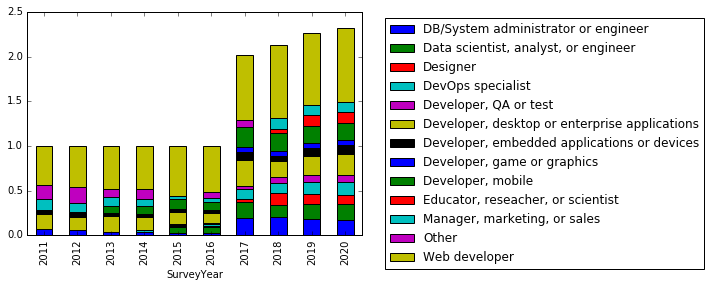

In [10]:
#
dfExp_DevType['numChoices'] = dfExp_DevType[list_choices(dfBig['DeveloperType'])].sum(axis=1)
display.display(dfExp_DevType.groupby('SurveyYear')['numChoices'].mean())

# ax, _ = bars_by_year(dfBig, 'DeveloperType', ntop=13,
#                   title='Type of developers by year')

dfCnt = counts_by_group(dfBig, 'DeveloperType')
dfCnt = dfCnt.drop('TOTAL', axis=0) / dfCnt.loc['TOTAL']

# # Reset the colors
# if color is None:
# #         color = cm.get_cmap('Set1')(np.arange(min(9, ntop))/9)
#     color = cm.ScalarMappable(cmap='jet').to_rgba(np.linspace(0, 1, min(ntop,by_year.shape[0]) ))

ax = dfCnt.T.plot.bar(stacked=True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# ax.set_title(title if title is not None else column)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display.display(dfCnt)

C:\Users\yma80\AppData\Local\Continuum\anaconda3\envs\py35\lib\site-packages\matplotlib\figure.py:397: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



SurveyYear     int64
Assembly        bool
Bash/Shell      bool
C               bool
C#              bool
C++             bool
Go              bool
HTML/CSS        bool
Java            bool
JavaScript      bool
Lisp            bool
Matlab          bool
Objective-C     bool
Other           bool
PHP             bool
Perl            bool
Python          bool
R               bool
Ruby            bool
SQL             bool
Scala           bool
VB/VB.NET       bool
Only Minor      bool
Any Minor       bool
dtype: object

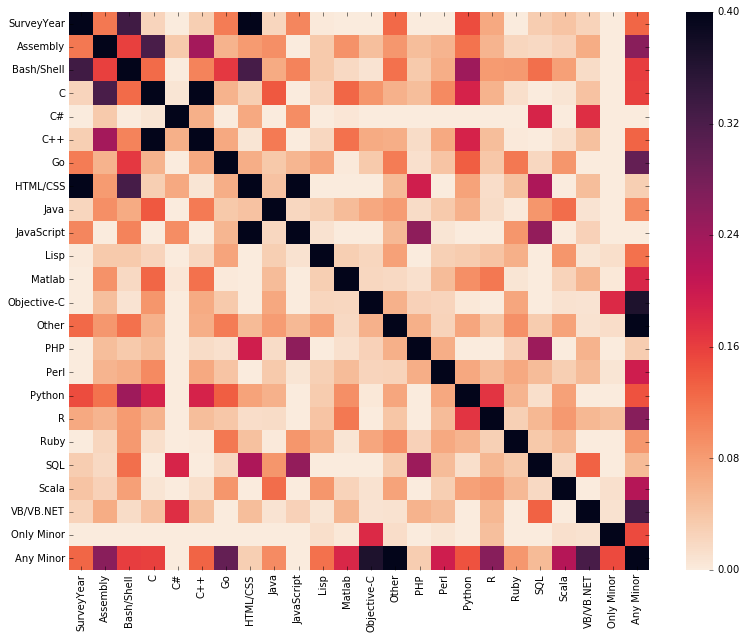

In [11]:
dfExp_Language['Only Minor'] = ~dfExp_Language[topLanguages].any(axis=1)       # .apply(lambda x: np.any(x), raw=True, axis=1) # <- use if contains NaNs
dfExp_Language['Any Minor'] = dfExp_Language[minorLanguages].any(axis=1)
dfExp_Language.head(25)


# col = 'HaveWorkedDatabase'
# # Find which multiple choice answers overlap with each other (i.e. present simultaneously in the database entries), and thus are good candidates to be merged
# ser = dfBig[col].dropna()   # We'll be working in a separate series
# choices = sorted(list( set(map(str.strip, set(';'.join(ser.values).split(';') ) )) ))      # All possible (individual) choices in the answers to the multiple choice question
# dfExp = pd.DataFrame().join([ser.str.contains(ch, regex=False).rename(ch).to_frame() for ch in choices], how='outer')    # An expanded datafrane with columns corresponding to every choice
# print(choices)

# Plot the correlation matrix
fig = plt.figure(figsize=(13, 10))
sn.heatmap(dfExp_Language.dropna().corr(), ax=fig.gca(), vmin=0, vmax=0.4, cmap='rocket_r')
fig.show()

dfExp_Language.dropna().dtypes

C:\Users\yma80\AppData\Local\Continuum\anaconda3\envs\py35\lib\site-packages\matplotlib\figure.py:397: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



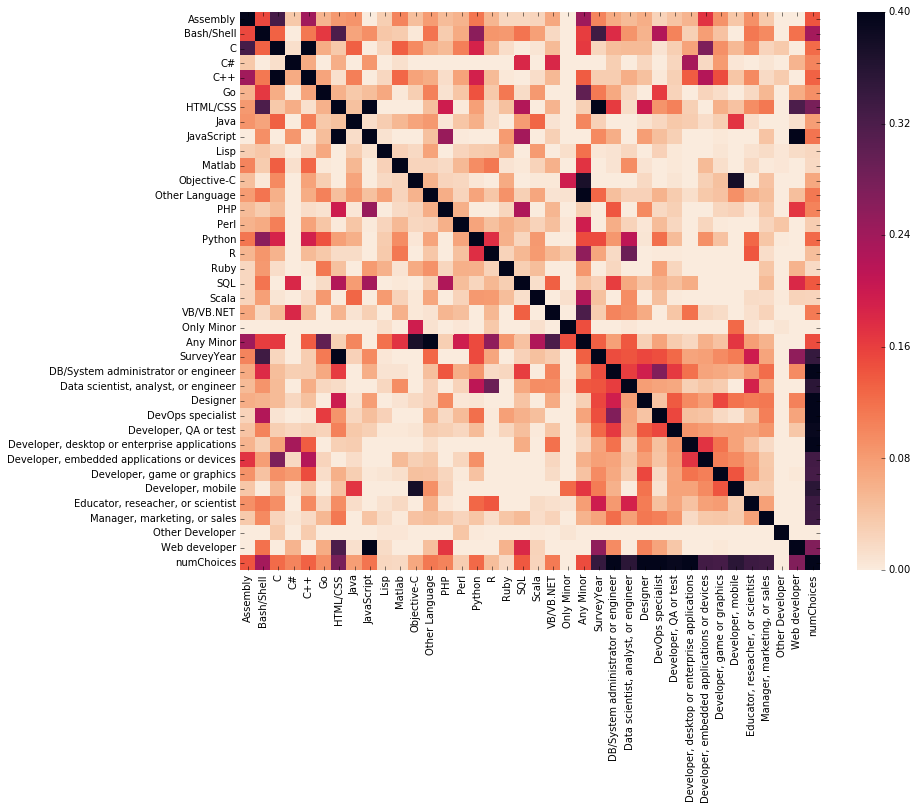

In [12]:
dfExp = dfExp_Language.drop(columns=['SurveyYear']).rename(columns={'Other':'Other Language'})\
        .join(dfExp_DevType.rename(columns={'Other':'Other Developer'}), how='inner')

# Plot the correlation matrix
fig = plt.figure(figsize=(13, 10))
sn.heatmap(dfExp.dropna().corr(), ax=fig.gca(), vmin=0, vmax=0.4, cmap='rocket_r')
fig.show()

In [11]:
#
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.datasets import load_boston

boston = load_boston()
df = pd.DataFrame(
    boston.data, columns=boston.feature_names)

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id="graph"),
    html.P("Number of components:"),
    dcc.Slider(
        id='slider',
        min=2, max=5, value=3,
        marks={i: str(i) for i in range(2,6)})
])

@app.callback(
    Output("graph", "figure"), 
    [Input("slider", "value")])
def run_and_plot(n_components):

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(df)

    var = pca.explained_variance_ratio_.sum() * 100

    labels = {str(i): "PC {}".format(i+1) 
              for i in range(n_components)}
    labels['color'] = 'Median Price'

    fig = px.scatter_matrix(
        components,
        color=boston.target,
        dimensions=range(n_components),
        labels=labels,
        title='Total Explained Variance: {:.2f}%'.format(var))
    fig.update_traces(diagonal_visible=False)
    return fig

app.run_server(debug=True)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


SystemExit: 1

C:\Users\yma80\AppData\Local\Continuum\anaconda3\envs\py35\lib\site-packages\IPython\core\interactiveshell.py:2870: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



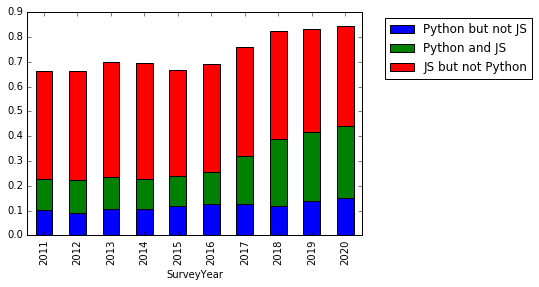

In [33]:
#
col = 'HaveWorkedLanguage'


# indx = dfExp['Student'].fillna(False)          # Only students


# dfCnt = counts_by_group(dfExp.loc[], col)


# dfCnt = dfExp.groupby('SurveyYear')[indx].count()

# display.display(dfCnt)
dfBig1 = dfBig#.loc[dfExp['Developer, mobile'].fillna(False), :]

total_by_year = dfBig1.loc[:,['SurveyYear', col]].groupby('SurveyYear').count().squeeze().rename('Total')
indx = (dfExp['Python'].fillna(False) & (~dfExp['JavaScript'].fillna(False)))
ser1 = (dfBig1.loc[indx, ['SurveyYear', col]].groupby('SurveyYear').count().squeeze() / total_by_year).rename('Python but not JS')
indx = ((~dfExp['Python'].fillna(False)) & (dfExp['JavaScript'].fillna(False)))
ser2 = (dfBig1.loc[indx, ['SurveyYear', col]].groupby('SurveyYear').count().squeeze() / total_by_year).rename('JS but not Python')
indx = ((dfExp['Python'].fillna(False)) & (dfExp['JavaScript'].fillna(False)))
ser3 = (dfBig1.loc[indx, ['SurveyYear', col]].groupby('SurveyYear').count().squeeze() / total_by_year).rename('Python and JS')

df = pd.DataFrame().join([ser1, ser3, ser2], how='outer')
ax = df.plot(kind='bar', stacked=True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

C:\Users\yma80\AppData\Local\Continuum\anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



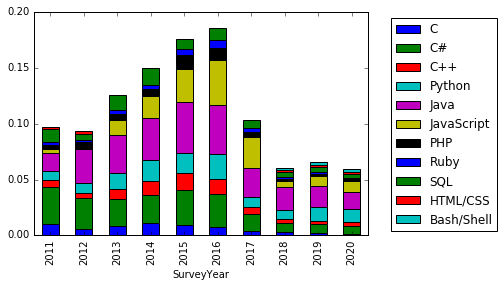

In [35]:
# Count how many people knew only a single language in each year
df = dfExp[['SurveyYear']+topLanguages]
df['NumOfLang'] = df[topLanguages].sum(axis=1)
total_by_year = dfBig.loc[:,['SurveyYear', 'HaveWorkedLanguage']].groupby('SurveyYear').count().squeeze().rename('Total')
df = df.loc[df['NumOfLang']==1, topLanguages+['SurveyYear']].groupby('SurveyYear').sum(axis=0).T / total_by_year
ax = df.T.plot(kind='bar', stacked=True, title='Know only a single language')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
# Believe in aliens by country
df = dfBig.groupby('Country')['BelieveAliens'].value_counts().unstack().reset_index()
df.fillna(0, inplace=True)
df['Total'] = df.sum(axis=1)
df['YesRatio'] = df['Yes'] / df['Total']
df['NoRatio'] = df['No'] / df['Total']
df['NetYes'] = df['YesRatio'] - df['NoRatio']
df.sort_values(by=['Total'], ascending=False, inplace=True)
df = df.loc[df['Total']>50]

df.head(100)

In [ ]:
# Cats or Dogs?
df = dfBig.groupby('Country')['CatsDogs'].value_counts().unstack().reset_index()
df.fillna(0, inplace=True)
df['Total'] = df.sum(axis=1)
df['CatsRatio'] = df['Cats'] / df['Total']
df['DogsRatio'] = df['Dogs'] / df['Total']
df['NetDogs'] = df['DogsRatio'] - df['CatsRatio']
df.sort_values(by=['Total'], ascending=False, inplace=True)
df = df.loc[df['Total']>50]

df.head(100)

In [ ]:
# Test
col = 'JobSeeking'
df = dfBig.dropna(subset=[col])
df = df.groupby('Country')[col].agg(lambda x : x.value_counts().index[0]).to_frame().reset_index()   # Find the mode
# # df.fillna(0, inplace=True)
# df['Total'] = df.sum(axis=1)
# # df['YesRatio'] = df['Yes'] / df['Total']
# # df['NoRatio'] = df['No'] / df['Total']
# # df['NetYes'] = df['YesRatio'] - df['NoRatio']
# df['Mode']
# df.sort_values(by=['Total'], ascending=False, inplace=True)
# # df = df.loc[df['Total']>25]

# # # print(dfBig_sch[2017].loc['ClickyKeys'])

# df = dfBig.groupby('Country')['PronounceGIF'].value_counts().unstack().reset_index()
# # df.fillna(0, inplace=True)
# # df['Total'] = df.sum(axis=1)
# # df['CatsRatio'] = df['Cats'] / df['Total']
# # df['DogsRatio'] = df['Dogs'] / df['Total']
# # df['NetDogs'] = df['DogsRatio'] - df['CatsRatio']
# # df.sort_values(by=['Total'], ascending=False, inplace=True)
# # df = df.loc[df['Total']>50]



df.head(100)

In [ ]:
(~dfBig.isnull()).sum(axis=0).sort_values(ascending=False)

In [ ]:
# Plot data on a map witk plotly

df['CountryCode'] = df['Country'].map({c.name:c.alpha_3 for c in pycountry.countries})    # Add the ISO country codes to the dataframe

fig = px.choropleth(df, locations="CountryCode",
                    color=col,
                    hover_name="Country",
                    color_continuous_scale=px.colors.sequential.RdBu,
                    color_continuous_midpoint = 0.0)   #                     animation_frame="date",


# fig["layout"].pop("updatemenus")
fig.update_geos(projection_type="natural earth")
fig.show()

### Part 5. Other Ideas to Explore
Below are some other things that are worth trying, but that have not been included in the final solution.

In [691]:
# Bipartite graph between DeveloperType and HaveWorkedLanguage
df = dfBig[['DeveloperType', 'HaveWorkedLanguage']].dropna().sample(frac=SAMPLE_FRAC, random_state=42)
df_dev = expand_multichoice(df, 'DeveloperType').drop(columns=['HaveWorkedLanguage']).replace({True:1, False:0})
df_lng = expand_multichoice(df, 'HaveWorkedLanguage').drop(columns=['DeveloperType']).replace({True:1, False:0})

C = df_dev.T.dot(df_lng)    # Adjacency matrix for the bipartite graph

# Scale each entry in the matrix such by the total number of _outgoing_ edges
edg_lng2dev = (C / df_lng.sum()).T       # 'x fraction of people who use lng are dev'
edg_dev2lng = (C.T / df_dev.sum()).T     # 'x fraction of people who are dev use lng'

edg_lng2dev
edg_dev2lng

,Assembly,Bash/Shell/PowerShell,C,C#,C++,Go,HTML/CSS,Java,JavaScript,Lisp,...,Objective-C,Other,PHP,Perl,Python,R,Ruby,SQL,Scala,VB/VB.NET
DB/System administrator or engineer,0.072295,0.442318,0.218424,0.377030,0.250726,0.102034,0.642796,0.405401,0.754230,0.014015,...,0.083234,0.214322,0.433259,0.051102,0.425397,0.054521,0.099128,0.754230,0.031960,0.134507
"Data scientist, analyst, or engineer",0.066360,0.336949,0.227574,0.283824,0.297794,0.075919,0.462132,0.411765,0.570588,0.017279,...,0.069669,0.199632,0.234191,0.036397,0.601838,0.196324,0.066544,0.633824,0.082904,0.125919
Designer,0.083875,0.337047,0.247601,0.372950,0.278552,0.060662,0.783039,0.433302,0.803466,0.011761,...,0.108635,0.211699,0.427731,0.028784,0.346951,0.044259,0.081089,0.632931,0.019808,0.128134
DevOps specialist,0.054942,0.545741,0.186383,0.333859,0.226604,0.193743,0.578339,0.435594,0.754469,0.019453,...,0.077550,0.247371,0.305731,0.053628,0.509464,0.047581,0.160358,0.643270,0.061514,0.069401
"Developer, QA or test",0.071165,0.431146,0.232902,0.391405,0.266174,0.104898,0.669593,0.488447,0.737523,0.013401,...,0.092421,0.216728,0.344732,0.033272,0.429298,0.045287,0.121072,0.657116,0.036044,0.116451
"Developer, desktop or enterprise applications",0.066929,0.279655,0.244348,0.560452,0.344806,0.057912,0.465837,0.436627,0.625603,0.007874,...,0.087630,0.183515,0.227965,0.028702,0.315469,0.032131,0.055118,0.620142,0.031242,0.131445
"Developer, embedded applications or devices",0.165678,0.373610,0.569681,0.374722,0.584136,0.085619,0.436990,0.432172,0.553373,0.012973,...,0.119348,0.221646,0.256116,0.036694,0.494070,0.037064,0.067457,0.472943,0.027428,0.094144
"Developer, game or graphics",0.116223,0.333535,0.345036,0.530872,0.513923,0.082324,0.595036,0.475787,0.690073,0.010896,...,0.150726,0.259080,0.341404,0.029056,0.435835,0.038741,0.079903,0.488499,0.028450,0.099879
"Developer, mobile",0.060534,0.239614,0.231157,0.349258,0.266320,0.059199,0.484125,0.591246,0.636053,0.008309,...,0.341246,0.262315,0.314540,0.019288,0.289169,0.028635,0.082344,0.496142,0.023145,0.072107
"Educator, reseacher, or scientist",0.117717,0.444533,0.317638,0.268555,0.383480,0.076217,0.633280,0.440942,0.636073,0.016361,...,0.085794,0.268555,0.283320,0.027534,0.591780,0.165603,0.078212,0.522745,0.048683,0.084198


0.1536281179138322
0.08387496131228722


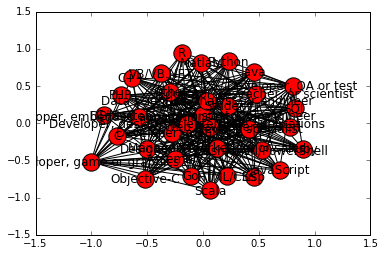

In [692]:
# Draw the graph
# for dev in list_choices(df['DeveloperType']):
#     for lng in list_choices(df['HaveWorkedLanguage']):
#         print(dev, lng)
#         dev2lng = 

print( df.loc[df['HaveWorkedLanguage'].str.contains('Assembly')]['DeveloperType'].str.contains('Designer', regex=False).mean() )
print( df.loc[df['DeveloperType'].str.contains('Designer')]['HaveWorkedLanguage'].str.contains('Assembly', regex=False).mean() )

import networkx as nx
B = nx.Graph()
B.add_nodes_from(edg_lng2dev.index, bipartite='lng')
B.add_nodes_from(edg_dev2lng.index, bipartite='dev')
B.add_weighted_edges_from(edg_dev2lng.stack().reset_index().apply(lambda row : tuple(row), axis=1).values)
B.add_weighted_edges_from(edg_lng2dev.stack().reset_index().apply(lambda row : tuple(row), axis=1).values)

nx.drawing.nx_pylab.draw_networkx(B)